In [1]:
import sys
sys.path.append('../../')

In [2]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [3]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation, data_preprocessing_high_dimension,model_training
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

In [17]:
european_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/european_volumetric_df.csv')
# mixed_volumetric_dataset_term = pd.read_csv(
#     preprocessed_dataset_path +
#     'imaging_data/volumetric/term/mixed_volumetric_df.csv')

In [18]:
all_PCs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files(file_path='../../dataset/ancestry_PCs/file3_only_europ_pca.eigenvec',column_prefix='euro_Anc_')

In [19]:
european_volumetric_dataset_term.shape

(208, 4511)

In [20]:
european_volumetric_dataset_term = pd.merge(european_volumetric_dataset_term,all_PCs[[f'euro_Anc_PC{i}' for i in range(11,101)]].reset_index(),
        on='ID',how='left')

In [21]:
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('AAL \d',i))
]
df = european_volumetric_dataset_term.copy()
# df = mixed_volumetric_dataset_term.copy()
# df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping=None)
# df = data_exploration.MassUnivariate.remove_outliers(df,
#                                                     col=dependentVar,
#                                                      threshold=3,
#                                                     remove_schemes='percentage',
#                                                     percentage_of_outlier=0.1)
df = df.rename(columns = {'AAL 93':'AAL 109'})
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]

In [73]:
# imputed_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_ASD_AllLDimputed')

PRS_ASD_EuroLD=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_Euro_LD')
# PRS_SCZ_EuroLD = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_eur_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_SCZ_Euro_LD')
# PRS_ASD_EuroLD_imputed=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_EuroLDimputed')

df = df.rename(columns={i:i+'_ASD_All_LD' for i in df.columns if 'PRS' in i})

# df = df.merge(imputed_PRS,left_on='ID',right_on=imputed_PRS.index)
df = df.merge(PRS_ASD_EuroLD,left_on='ID',right_on=PRS_ASD_EuroLD.index)
# df = df.merge(PRS_SCZ_EuroLD,left_on='ID',right_on=PRS_SCZ_EuroLD.index)


# df = df.merge(PRS_ASD_EuroLD_imputed,left_on='ID',right_on=PRS_ASD_EuroLD_imputed.index)

In [8]:
df.shape

(245, 4610)

In [9]:
# # plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['patch.edgecolor'] = 'none'
# plt.rcParams["axes.grid.axis"] ="y"
# sns.set_style('whitegrid')
# g = sns.FacetGrid(mixed_volumetric_dataset_term[['GA_vol','PMA_vol','cohort']],col='cohort',height = 4)
# g.map(sns.histplot,'GA_vol',label='GA at birth',color='darkblue',alpha=0.15,shrink=.8)
# g.map(sns.histplot,'PMA_vol',label='PMA at scan',color='darkblue',alpha=0.5,shrink=.8)
# g.set_ylabels('Number of subjects',fontsize=15)
# g.set_xlabels('[weeks]',fontsize=15,fontname='Helvetica')
# g.axes[0][0].set_yticklabels(([int(i) for i in g.axes[0][0].get_yticks()]),size=15)
# g.axes[0][0].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)
# g.axes[0][1].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)


# g.axes[0][0].set_title('cohort = European',size=15)
# g.axes[0][1].set_title('cohort = Asian',size=15)
# plt.legend(ncol=2,loc='upper center',fontsize=15,frameon=False)
# sns.despine(bottom=True,left=True)
# # g.savefig(f'./{preprocessed_dataset_path}/output_plot/Cohort_age_distribution.pdf',transparent=True)

## AAL atlas

In [88]:
combined = df[[
    i for i in df.columns
    if bool(re.search('AAL \d', i))
]].copy()
# combined = df[[i for i in df.columns if ('PRS' in i)]]
correlation_matrix = np.corrcoef(combined, rowvar=False)
_ = data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 47.175858187992
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 28.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0017857142857142872


In [90]:
0.05/92

0.0005434782608695652

In [86]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# ancestry = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('AAL \d',i))]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=['prs_pca'],
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=dependentVar_cols)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


In [87]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
56,AAL 57,4988.239611,5.797515e-196,-50.910598,0.134877,121.836870,0.014484,622.886160,2.982100e-34,-19.059251,0.470427,22.056085,0.399540,46.660927,0.068504,-88.204926,0.000956,181.456235,0.001499,prs_pca
3,AAL 4,4939.628573,5.675650e-186,-8.247320,0.827578,-4.630721,0.933076,774.041069,1.965891e-39,29.946971,0.309462,-60.587153,0.038848,-32.043587,0.260674,88.551691,0.002867,-16.047501,0.798689,prs_pca
64,AAL 65,3534.646005,2.779958e-165,47.464500,0.172298,29.812550,0.555352,476.156520,8.446829e-23,-9.162912,0.734023,-3.688263,0.890247,10.072581,0.699187,-73.677644,0.006673,-87.468361,0.130326,prs_pca
26,AAL 27,1352.208993,6.292098e-183,9.835535,0.360630,-17.779173,0.256804,187.988518,3.974161e-32,-9.561859,0.253109,-10.495172,0.205882,16.157834,0.046458,22.523669,0.007414,-22.716170,0.204313,prs_pca
19,AAL 20,3437.955031,9.481456e-174,-27.613596,0.365603,16.595729,0.708649,496.603724,3.952005e-29,0.313031,0.989460,-44.054710,0.061869,-0.510568,0.982215,60.022014,0.011803,3.230347,0.949160,prs_pca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,AAL 83,1708.678729,3.509255e-176,-29.753101,0.044331,-0.479873,0.982141,189.341316,1.023504e-20,1.112523,0.922527,-23.286920,0.041085,2.394108,0.828589,-0.878430,0.938659,-21.648346,0.376576,prs_pca
39,AAL 40,1604.842362,6.404843e-189,12.189894,0.305389,-30.507282,0.078975,170.508411,2.408860e-24,4.771793,0.605321,2.498056,0.784867,9.208980,0.302659,-0.558519,0.951648,-9.536692,0.629049,prs_pca
12,AAL 13,4874.586702,1.926010e-184,-5.572531,0.883571,76.729720,0.167223,707.429327,7.299787e-35,28.704619,0.332310,-38.329919,0.191993,-45.127669,0.115538,0.511546,0.986169,41.816764,0.508621,prs_pca
36,AAL 37,699.971541,6.158447e-184,-2.532146,0.645143,-1.169921,0.883819,67.975007,1.578326e-19,-0.552713,0.897063,0.034582,0.993484,2.867442,0.487691,-0.047141,0.991177,-5.758153,0.528644,prs_pca


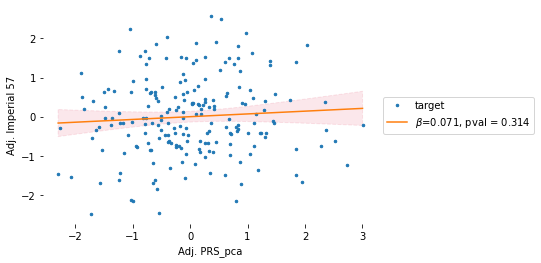

In [91]:
ylabel='Imperial 57'
xlabel = 'PRS_pca'
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=[ylabel])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['prs_pca'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel=f'Adj. {xlabel}', ylabel=f'Adj. {ylabel}',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [23]:
_,prs_pca,_ = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
df = df,
dependentVar_cols=[i for i in df.columns if 'PRS' in i],
scaling=True,
n_components=1)

In [24]:
df['prs_pca'] = prs_pca

In [25]:
# dependentVar_cols=[i for i in combined.columns if bool(re.search('Imperial \d',i))]
# dependentVar_cols = data_preprocessing.Volumes.extract_GM_Imperial(dependentVar_cols)
# df = european_volumetric_dataset_term
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('AAL \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components = .8)

In [32]:
thresholds = [i for i in df.columns if 'PRS' in i]
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=['prs_pca'],
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=X_pca)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.06it/s]


In [42]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if ('PRS' in i)]
temp = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval').copy()

In [33]:
european_volumetric_term_mass_univariate

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
0,Dependent_Var_0,0.184206,0.078600,-0.076416,0.423407,0.327429,2.235520e-02,7.855456,1.203549e-135,-0.046094,0.539857,-0.174259,0.020187,0.034242,0.637154,-0.035527,0.636649,-0.390967,0.015677,prs_pca
1,Dependent_Var_1,0.237325,0.110448,-0.054388,0.688202,-0.116429,5.651015e-01,-0.028397,8.693349e-01,0.025575,0.810704,0.029199,0.782693,-0.206434,0.046352,0.113563,0.288374,-0.503710,0.028223,prs_pca
2,Dependent_Var_2,-0.041667,0.752278,-0.242746,0.045353,0.442813,1.471346e-02,-0.227281,1.403893e-01,-0.021158,0.823931,-0.111648,0.237125,0.050895,0.579555,0.007459,0.937506,0.088436,0.663503,prs_pca
3,Dependent_Var_3,-0.025240,0.825864,-0.146158,0.164491,0.793450,8.930112e-07,-0.506809,1.938142e-04,-0.061653,0.455978,0.060432,0.461089,-0.001489,0.985119,-0.299715,0.000361,0.053571,0.761674,prs_pca
4,Dependent_Var_4,-0.008359,0.946459,-0.060259,0.596594,0.354162,3.815809e-02,-0.195893,1.776299e-01,-0.010813,0.904020,0.060457,0.496742,0.098864,0.254371,-0.108842,0.225885,0.017742,0.926240,prs_pca
5,Dependent_Var_5,0.131697,0.193349,0.315412,0.000763,-0.671050,2.250606e-06,0.368061,1.999957e-03,-0.001022,0.988796,-0.052429,0.467797,0.215235,0.002470,-0.154826,0.034485,-0.279520,0.073494,prs_pca


In [61]:
0.05/7

0.0071428571428571435

In [57]:
df['Brain_PC1'] = X_pca[:,0]
df['Brain_PC2'] = X_pca[:,1]
df['Brain_PC3'] = X_pca[:,2]
df['Brain_PC4'] = X_pca[:,3]
df['Brain_PC5'] = X_pca[:,4]
df['Brain_PC6'] = X_pca[:,5]

<AxesSubplot:>

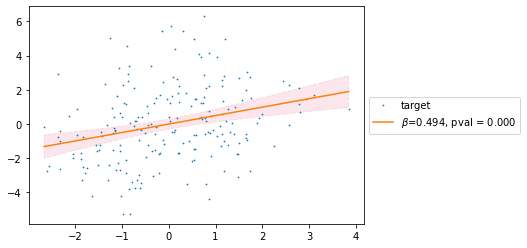

In [60]:
visualisation.plot_Linear_Reg(x='Brain_PC4',
                             y='prs_pca',
                             data=df,scaling=True,
                             )

In [44]:
temp

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,...,euro_Anc_PC13_pval,euro_Anc_PC14_coef,euro_Anc_PC14_pval,euro_Anc_PC15_coef,euro_Anc_PC15_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
52,Dependent_Var_3,0.045554,0.694107,0.060027,0.581142,-0.845157,3.188411e-07,0.551538,5.388006e-05,0.001802,...,0.189716,-0.177495,0.057361,-0.193705,0.041392,0.279877,0.000751,-0.096274,0.592372,PRS_0.05
59,Dependent_Var_3,0.053060,0.647764,0.055896,0.608330,-0.838898,4.110323e-07,0.554463,5.195260e-05,-0.004328,...,0.178117,-0.191199,0.041813,-0.178134,0.061855,0.266055,0.001408,-0.112137,0.533792,PRS_0.1
45,Dependent_Var_3,0.025150,0.829505,0.061414,0.574554,-0.829780,5.450383e-07,0.549856,6.091322e-05,0.002546,...,0.274210,-0.184540,0.049390,-0.164374,0.086349,0.266564,0.001777,-0.053153,0.770162,PRS_0.01
3,Dependent_Var_3,0.053306,0.648206,-0.007960,0.942202,-0.754846,5.988215e-06,0.520669,1.632818e-04,-0.001013,...,0.154467,-0.146330,0.121448,-0.211092,0.027900,0.236553,0.004617,-0.112657,0.534361,PRS_1e-08
10,Dependent_Var_3,0.044488,0.703940,0.027165,0.803820,-0.767393,4.100298e-06,0.520657,1.663826e-04,0.004176,...,0.198587,-0.180379,0.055986,-0.201242,0.035979,0.233790,0.005684,-0.094021,0.605103,PRS_1e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Dependent_Var_1,0.259740,0.095080,-0.143481,0.325438,-0.084674,6.939897e-01,0.006340,9.718648e-01,-0.027525,...,0.971504,-0.020551,0.869405,0.065063,0.607393,-0.015396,0.888313,-0.548935,0.023422,PRS_1e-08
51,Dependent_Var_2,-0.054104,0.697089,-0.301206,0.021936,0.579112,2.796664e-03,-0.282278,7.945539e-02,-0.020716,...,0.500802,-0.007198,0.948534,-0.056866,0.615923,-0.009226,0.925083,0.114344,0.596173,PRS_0.05
25,Dependent_Var_4,0.006703,0.958316,0.028357,0.811606,-0.222191,2.040070e-01,0.155952,2.873298e-01,0.024133,...,0.539445,0.148627,0.148334,-0.001682,0.987039,0.006309,0.945026,-0.014166,0.943765,PRS_1e-05
63,Dependent_Var_0,0.242010,0.024022,-0.108517,0.276764,0.358334,1.539144e-02,7.771292,6.272872e-127,0.009593,...,0.777106,-0.000130,0.998793,-0.037612,0.667236,-0.003335,0.965296,-0.511465,0.002259,PRS_0.5


In [88]:
df.to_csv('./preprocessed_dataset/genetic_data/eur/european_data_with_PCA.csv',index=False)

In [80]:
temp

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
122,Dependent_Var_3,0.030171,0.794217,0.038325,0.720670,-0.789434,9.352137e-07,0.512313,1.276253e-04,0.041837,0.614004,-0.091565,0.266762,-0.078021,0.332557,0.299650,0.000335,-0.063764,0.719653,PRS_0.01_ASD_Euro_LD
129,Dependent_Var_3,0.044851,0.700891,0.025109,0.816475,-0.764431,2.433855e-06,0.497402,2.336852e-04,0.045038,0.592188,-0.076822,0.354921,-0.057952,0.474955,0.243355,0.003528,-0.094788,0.596543,PRS_0.05_ASD_Euro_LD
80,Dependent_Var_3,0.065723,0.573192,-0.027666,0.799051,-0.700962,1.749200e-05,0.475488,4.660383e-04,0.037132,0.658585,-0.058014,0.483710,-0.076579,0.348568,0.230970,0.005393,-0.138898,0.436339,PRS_1e-08_ASD_Euro_LD
136,Dependent_Var_3,0.055925,0.632743,0.013579,0.900333,-0.757473,3.237157e-06,0.499993,2.294804e-04,0.044220,0.600624,-0.085665,0.307057,-0.055495,0.495531,0.220299,0.008392,-0.118192,0.509506,PRS_0.1_ASD_Euro_LD
108,Dependent_Var_3,0.014480,0.903071,0.007346,0.945962,-0.747344,4.367925e-06,0.499890,2.307608e-04,0.026396,0.753448,-0.059750,0.471782,-0.075212,0.358256,0.225354,0.008707,-0.030602,0.868317,PRS_0.0001_ASD_Euro_LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Dependent_Var_4,-0.000698,0.995635,0.028280,0.810028,-0.208325,2.247332e-01,0.159728,2.685787e-01,0.007285,0.936157,0.010564,0.906860,0.099556,0.259191,0.006143,0.945803,0.001475,0.994015,PRS_1e-05_ASD_Euro_LD
123,Dependent_Var_4,0.001229,0.992283,0.026992,0.818657,-0.207488,2.269285e-01,0.159831,2.682889e-01,0.006674,0.941593,0.011890,0.895395,0.100163,0.257665,-0.005298,0.953200,-0.002597,0.989380,PRS_0.01_ASD_Euro_LD
111,Dependent_Var_6,-0.002255,0.982811,0.145496,0.128334,0.015382,9.121187e-01,-0.053788,6.469505e-01,0.070255,0.342704,-0.051609,0.480082,-0.015527,0.829226,0.003775,0.959833,0.004765,0.976600,PRS_0.0001_ASD_Euro_LD
133,Dependent_Var_0,0.197700,0.062085,-0.081619,0.404233,0.330638,2.135149e-02,7.801255,1.595447e-134,-0.037729,0.620337,-0.170332,0.025033,0.033154,0.651486,-0.003567,0.961910,-0.417819,0.010298,PRS_0.1_ASD_Euro_LD


In [101]:
temp = temp.set_index(['threshold','Connection'])
temp = temp.sort_index()

In [102]:
temp.to_excel('./temp.xlsx')

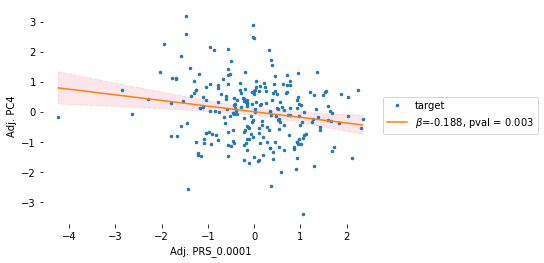

In [33]:
# PC4 was associated with the PRS 0.01 and 0.05
xlabel = 'PRS_0.0001'
ylabel = 'PC4'
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)'],
    dependentVar_cols=X_pca[:,3].reshape(-1,1))
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=[xlabel])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel=f'Adj. {xlabel}', ylabel=f'Adj. {ylabel}',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [56]:
data_exploration.MassUnivariate.get_model_summary(df,
                                                 cat_independentVar_cols=['Gender'],
                                                  cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)','PRS_0.01_ASD_Euro_LD']+ancestry,
                                                  dependentVar_cols=X_pca[:,3].reshape(-1,1))

,beta_coefs,pvalues,Rsquared
const,0.023571,7.942173e-01,0.000262
PMA_vol,-0.616736,9.352137e-07,0.098641
GA_vol,0.029941,7.206704e-01,0.000493
17 ICV (all except bone),0.400239,1.276253e-04,0.058729
PRS_0.01_ASD_Euro_LD,0.234098,3.346392e-04,0.051242
euro_Anc_PC1,0.032685,6.140040e-01,0.000981
euro_Anc_PC2,-0.071534,2.667620e-01,0.004767
euro_Anc_PC3,-0.060953,3.325570e-01,0.003627
Gender_2.0,-0.049815,7.196534e-01,0.000497


In [36]:
data_exploration.MassUnivariate.get_model_summary(df,
                                                 cat_independentVar_cols=['Gender'],
                                                  cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)','PRS_0.01']+ancestry,
                                                  dependentVar_cols=X_pca[:,3].reshape(-1,1))

,beta_coefs,pvalues,Rsquared
const,-0.036924,7.304311e-01,0.000396
PMA_vol,0.789065,3.778893e-07,0.090966
GA_vol,-0.104081,3.031896e-01,0.003543
17 ICV (all except bone),-0.523000,5.004330e-05,0.056811
PRS_0.01,-0.179119,2.196493e-02,0.017697
mixed_Anc_PC1,-0.071652,4.162377e-01,0.002207
mixed_Anc_PC2,0.059655,4.286204e-01,0.002092
mixed_Anc_PC3,-0.079974,2.901456e-01,0.003740
mixed_Anc_PC4,0.080736,3.508800e-01,0.002907
mixed_Anc_PC5,-0.103471,1.869476e-01,0.005828


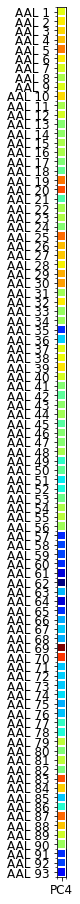

In [43]:
#see the loading matrix of PC4
fig,ax = plt.subplots(1,1,figsize=(20,16))
visualisation.visualise_heatmap(loading_matrix.loc[:,3:3],ax,xlabel=['PC4'],ylabel=loading_matrix.index.tolist())

In [41]:
plot_labels = [int(i.replace('AAL ','')) for i in loading_matrix.index]
plot_value_values = loading_matrix[3].values
plot_values = dict(zip(plot_labels,plot_value_values)) 

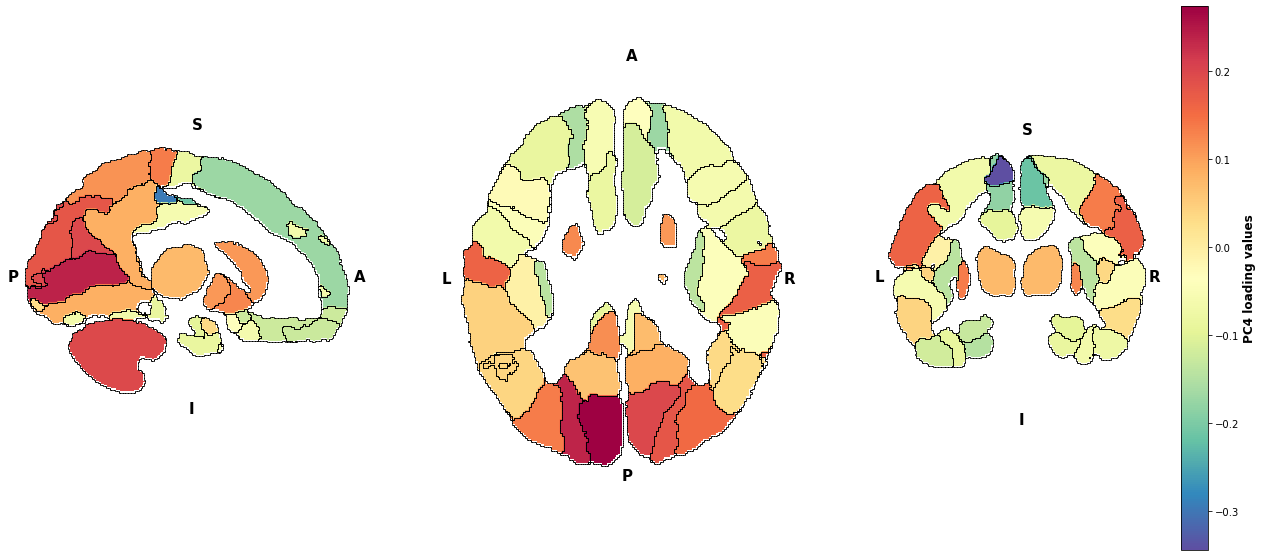

In [42]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],atlas_slice=120,plot_values=plot_values,colorbar=True,atlas_file = '../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',cb_orientation='vertical',cmap_reversed=True,cb_title = 'PC4 loading values')

In [27]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

<AxesSubplot:>

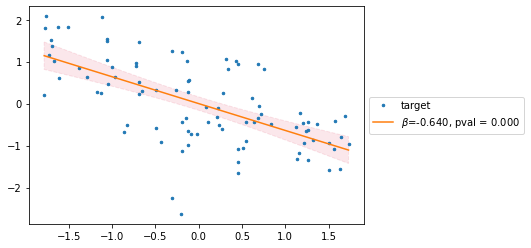

In [40]:
visualisation.plot_Linear_Reg(ROIs_coord.loc[0:92,'Y'],loading_matrix[3],markersize=5)

### Stability test

#### Halving the samples and then PCA

In [101]:
prs_cols = [i for i in df.columns if 'Euro' in i]
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
brain_regions = [i for i in df.columns if bool(re.search('AAL \d',i))]

In [293]:
model_summary = defaultdict(dict)
for split_number in range(1,11):
    set1,set2 = data_exploration.Stability_tests.train_test_split_modified(df,
                                                                           'GA_vol',
                                                                           'PMA_vol',
                                                                           test_size=0.5,
                                                                           random_state=split_number)
    dependentVar_cols = [
        i for i in df.columns
        if bool(re.search('AAL \d', i))
    ]
    _, X_pca_set1, loading_matrix1 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
        df=set1,
        dependentVar_cols=dependentVar_cols,
        scaling=True,n_components = .8)
    _, X_pca_set2, loading_matrix2 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
        df=set2,
        dependentVar_cols=dependentVar_cols,
        scaling=True,n_components = .8)
    model_summary[f'split_{split_number}']=defaultdict(dict)
    model_summary[f'split_{split_number}']['set1']['loading_matrix']=loading_matrix1
    model_summary[f'split_{split_number}']['set2']['loading_matrix']=loading_matrix2

    set1_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=set1,
        thresholds=prs_cols,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
        dependentVar_cols=X_pca_set1)
    set2_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=set2,
        thresholds = prs_cols,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
        dependentVar_cols=X_pca_set2)
    
    set1_mass_univariate['set'] = 'set1'
    set2_mass_univariate['set'] = 'set2'
    set1_mass_univariate['split'] = f'split_{split_number}'
    set2_mass_univariate['split'] = f'split_{split_number}'
    
    set1_mass_univariate['Y_corr'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix1[int(x.split('_')[-1])].values)[0])
    set1_mass_univariate['Y_corr_pval'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix1[int(x.split('_')[-1])].values)[1])
    set1_mass_univariate['Z_corr'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix1[int(x.split('_')[-1])].values)[0])
    set1_mass_univariate['Z_corr_pval'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix1[int(x.split('_')[-1])].values)[1])
    
    
    set2_mass_univariate['Y_corr'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix2[int(x.split('_')[-1])].values)[0])
    set2_mass_univariate['Y_corr_pval'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix2[int(x.split('_')[-1])].values)[1])
    set2_mass_univariate['Z_corr'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix2[int(x.split('_')[-1])].values)[0])
    set2_mass_univariate['Z_corr_pval'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix2[int(x.split('_')[-1])].values)[1])
    
    model_summary[f'split_{split_number}']['set1']['mass_univariate']=set1_mass_univariate
    model_summary[f'split_{split_number}']['set2']['mass_univariate']=set2_mass_univariate


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 53.56it/s]


In [348]:
model_summary_mass_unvariate = pd.concat([model_summary[i][n]['mass_univariate'] for i in model_summary.keys() for n in ['set1','set2']])

In [357]:
temp = model_summary_mass_unvariate[(model_summary_mass_unvariate['Z_corr_pval']<0.05)].copy()
temp = temp.sort_values(by='PRS_pval')
temp = temp[temp['PRS_pval']<0.05]

In [358]:
temp = temp.set_index(['split','threshold','set'])

In [359]:
temp = temp.groupby(temp.index).head(1)

In [360]:
index_like = pd.DataFrame(columns=temp.columns,index = pd.MultiIndex.from_frame(model_summary_mass_unvariate[['split','threshold','set']]).drop_duplicates())

In [361]:
temp = temp.reindex(index_like.index)

In [362]:
temp = temp.reset_index()
temp['split'] = pd.Categorical(values=temp['split'],categories=[f'split_{i}' for i in range(1,11)],ordered=True)
temp['threshold'] = pd.Categorical(values=temp['threshold'],categories=prs_cols,ordered=True)
temp['set'] = pd.Categorical(values=temp['set'],categories=['set1','set2'],ordered=True)
temp = temp.set_index(['split','threshold','set'])

In [363]:
temp = temp.sort_index()

In [364]:
temp[['Connection','PMA_vol_coef','PMA_vol_pval','PRS_coef','PRS_pval','Y_corr','Y_corr_pval','Z_corr','Z_corr_pval']].to_excel('./temp.xlsx')

#### Random stratified split then PCA

In [15]:
prs_cols = [i for i in df.columns if 'Euro' in i]
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
brain_regions = [i for i in df.columns if bool(re.search('AAL \d',i))]

In [109]:
model_summary = defaultdict(dict)
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=brain_regions,
    scaling=True,n_components = .8)

df['Brain_PC1'] = X_pca[:,1]
df['Brain_PC2'] = X_pca[:,2]
df['Brain_PC3'] = X_pca[:,3]
df['Brain_PC4'] = X_pca[:,4]
df['Brain_PC5'] = X_pca[:,5]

for split_number in range(1,11):
    train,test = data_exploration.Stability_tests.train_test_split_modified(df,
                                                                           'GA_vol',
                                                                           'PMA_vol',
                                                                           test_size=0.3,
                                                                           random_state=split_number)
    model_summary[f'split_{split_number}']['train']=defaultdict()
    model_summary[f'split_{split_number}']['test']=defaultdict()
    train_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=train,
        thresholds=prs_cols,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
        dependentVar_cols=[i for i in train.columns if 'Brain_PC' in i])

    test_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=test,
        thresholds = prs_cols,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
        dependentVar_cols=[i for i in test.columns if 'Brain_PC' in i])
    
    train_mass_univariate['set'] = 'train'
    test_mass_univariate['set'] = 'test'
    train_mass_univariate['split'] = f'split_{split_number}'
    test_mass_univariate['split'] = f'split_{split_number}'
    
    model_summary[f'split_{split_number}']['train']['mass_univariate']=train_mass_univariate
    model_summary[f'split_{split_number}']['test']['mass_univariate']=test_mass_univariate

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 59.48it/s]


In [110]:
model_summary_mass_unvariate = pd.concat([model_summary[i][n]['mass_univariate'] for i in model_summary.keys() for n in ['train','test']])

In [112]:
# temp = model_summary_mass_unvariate[(model_summary_mass_unvariate['Y_corr_pval']<0.05)].copy()
temp = model_summary_mass_unvariate.copy()
temp = temp.sort_values(by='PRS_pval')
temp = temp[temp['PRS_pval']<0.05]

In [113]:
temp = temp.set_index(['split','threshold','Connection','set'])

In [114]:
temp

const_coef  const_pval  \
split    threshold             Connection set                             
split_7  PRS_0.01_ASD_Euro_LD  Brain_PC3  train    0.024758    0.846763   
split_5  PRS_0.01_ASD_Euro_LD  Brain_PC3  train    0.056166    0.666859   
split_6  PRS_1e-08_ASD_Euro_LD Brain_PC3  test    -0.112386    0.564032   
split_3  PRS_0.01_ASD_Euro_LD  Brain_PC5  test     0.237372    0.167242   
split_5  PRS_1e-07_ASD_Euro_LD Brain_PC3  test    -0.181136    0.449516   
...                                                     ...         ...   
split_10 PRS_0.05_ASD_Euro_LD  Brain_PC3  test    -0.238653    0.252975   
         PRS_1e-05_ASD_Euro_LD Brain_PC5  train    0.184568    0.134274   
split_8  PRS_0.5_ASD_Euro_LD   Brain_PC1  test    -0.105555    0.666234   
split_10 PRS_0.1_ASD_Euro_LD   Brain_PC3  test    -0.236672    0.257186   
         PRS_1e-08_ASD_Euro_LD Brain_PC3  train    0.160207    0.264218   

                                                 GA_vol_coef  GA_vol_pval  \
split    threshold             Connection set                               
split_7  PRS_0.01_ASD_Euro_LD  Brain_PC3  train     0.011032     0.927127   
split_5  PRS_0.01_ASD_Euro_LD  Brain_PC3  train     0.140068     0.279809   
split_6  PRS_1e-08_ASD_Euro_LD Brain_PC3  test     -0.183060     0.361844   
split_3  PRS_0.01_ASD_Euro_LD  Brain_PC5  test      0.190068     0.292758   
split_5  PRS_1e-07_ASD_Euro_LD Brain_PC3  test     -0.066346     0.722204   
...                                                      ...          ...   
split_10 PRS_0.05_ASD_Euro_LD  Brain_PC3  test      0.012736     0.947354   
         PRS_1e-05_ASD_Euro_LD Brain_PC5  train     0.319673     0.005434   
split_8  PRS_0.5_ASD_Euro_LD   Brain_PC1  test      0.098190     0.653923   
split_10 PRS_0.1_ASD_Euro_LD   Brain_PC3  test      0.002754     0.988599   
         PRS_1e-08_ASD_Euro_LD Brain_PC3  train     0.011146     0.934090   

                                                 PMA_vol_coef  PMA_vol_pval  \
split    threshold             Connection set                                 
split_7  PRS_0.01_ASD_Euro_LD  Brain_PC3  train     -0.799811      0.000028   
split_5  PRS_0.01_ASD_Euro_LD  Brain_PC3  train     -0.941068      0.000007   
split_6  PRS_1e-08_ASD_Euro_LD Brain_PC3  test      -0.156053      0.593832   
split_3  PRS_0.01_ASD_Euro_LD  Brain_PC5  test      -0.740806      0.002084   
split_5  PRS_1e-07_ASD_Euro_LD Brain_PC3  test      -0.758989      0.004840   
...                                                       ...           ...   
split_10 PRS_0.05_ASD_Euro_LD  Brain_PC3  test      -0.645891      0.021521   
         PRS_1e-05_ASD_Euro_LD Brain_PC5  train     -0.687614      0.000053   
split_8  PRS_0.5_ASD_Euro_LD   Brain_PC1  test      -0.311723      0.295299   
split_10 PRS_0.1_ASD_Euro_LD   Brain_PC3  test      -0.650522      0.020706   
         PRS_1e-08_ASD_Euro_LD Brain_PC3  train     -0.730804      0.000347   

                                                 17 ICV (all except bone)_coef  \
split    threshold             Connection set                                    
split_7  PRS_0.01_ASD_Euro_LD  Brain_PC3  train                       0.496133   
split_5  PRS_0.01_ASD_Euro_LD  Brain_PC3  train                       0.651392   
split_6  PRS_1e-08_ASD_Euro_LD Brain_PC3  test                        0.241737   
split_3  PRS_0.01_ASD_Euro_LD  Brain_PC5  test                        0.333688   
split_5  PRS_1e-07_ASD_Euro_LD Brain_PC3  test                        0.496634   
...                                                                        ...   
split_10 PRS_0.05_ASD_Euro_LD  Brain_PC3  test                        0.447763   
         PRS_1e-05_ASD_Euro_LD Brain_PC5  train                       0.299513   
split_8  PRS_0.5_ASD_Euro_LD   Brain_PC1  test                        0.322155   
split_10 PRS_0.1_ASD_Euro_LD   Brain_PC3  test                        0.465656   
         PRS_1e-08_ASD_Euro_LD Brain_PC3  train            

In [115]:
index_like = pd.DataFrame(columns=temp.columns,index = pd.MultiIndex.from_frame(model_summary_mass_unvariate[['split','threshold','Connection','set']]).drop_duplicates())

In [116]:
temp = temp.reindex(index_like.index)

In [117]:
temp

const_coef  const_pval  \
split    threshold             Connection set                             
split_1  PRS_1e-08_ASD_Euro_LD Brain_PC1  train         NaN         NaN   
                               Brain_PC2  train         NaN         NaN   
                               Brain_PC3  train         NaN         NaN   
                               Brain_PC4  train         NaN         NaN   
                               Brain_PC5  train         NaN         NaN   
...                                                     ...         ...   
split_10 PRS_1_ASD_Euro_LD     Brain_PC1  test          NaN         NaN   
                               Brain_PC2  test          NaN         NaN   
                               Brain_PC3  test    -0.284487    0.166055   
                               Brain_PC4  test          NaN         NaN   
                               Brain_PC5  test          NaN         NaN   

                                                 GA_vol_coef  GA_vol_pval  \
split    threshold             Connection set                               
split_1  PRS_1e-08_ASD_Euro_LD Brain_PC1  train          NaN          NaN   
                               Brain_PC2  train          NaN          NaN   
                               Brain_PC3  train          NaN          NaN   
                               Brain_PC4  train          NaN          NaN   
                               Brain_PC5  train          NaN          NaN   
...                                                      ...          ...   
split_10 PRS_1_ASD_Euro_LD     Brain_PC1  test           NaN          NaN   
                               Brain_PC2  test           NaN          NaN   
                               Brain_PC3  test     -0.004848     0.979349   
                               Brain_PC4  test           NaN          NaN   
                               Brain_PC5  test           NaN          NaN   

                                                 PMA_vol_coef  PMA_vol_pval  \
split    threshold             Connection set                                 
split_1  PRS_1e-08_ASD_Euro_LD Brain_PC1  train           NaN           NaN   
                               Brain_PC2  train           NaN           NaN   
                               Brain_PC3  train           NaN           NaN   
                               Brain_PC4  train           NaN           NaN   
                               Brain_PC5  train           NaN           NaN   
...                                                       ...           ...   
split_10 PRS_1_ASD_Euro_LD     Brain_PC1  test            NaN           NaN   
                               Brain_PC2  test            NaN           NaN   
                               Brain_PC3  test      -0.691777      0.011799   
                               Brain_PC4  test            NaN           NaN   
                               Brain_PC5  test            NaN           NaN   

                                                 17 ICV (all except bone)_coef  \
split    threshold             Connection set                                    
split_1  PRS_1e-08_ASD_Euro_LD Brain_PC1  train                            NaN   
                               Brain_PC2  train                            NaN   
                               Brain_PC3  train                            NaN   
                               Brain_PC4  train                            NaN   
                               Brain_PC5  train                            NaN   
...                                                                        ...   
split_10 PRS_1_ASD_Euro_LD     Brain_PC1  test                             NaN   
                               Brain_PC2  test                             NaN   
                               Brain_PC3  test                        0.500826   
                               Brain_PC4  test                             NaN   
                               Brain_PC5  test             

In [118]:
temp = temp.reset_index()
temp['split'] = pd.Categorical(values=temp['split'],categories=[f'split_{i}' for i in range(1,11)],ordered=True)
temp['threshold'] = pd.Categorical(values=temp['threshold'],categories=prs_cols,ordered=True)
temp['set'] = pd.Categorical(values=temp['set'],categories=['train','test'],ordered=True)
temp = temp.set_index(['split','threshold','Connection','set'])

In [119]:
temp = temp.sort_index()

In [120]:
temp

const_coef  const_pval  \
split    threshold             Connection set                             
split_1  PRS_1e-08_ASD_Euro_LD Brain_PC1  train         NaN         NaN   
                                          test          NaN         NaN   
                               Brain_PC2  train         NaN         NaN   
                                          test          NaN         NaN   
                               Brain_PC3  train         NaN         NaN   
...                                                     ...         ...   
split_10 PRS_1_ASD_Euro_LD     Brain_PC3  test    -0.284487    0.166055   
                               Brain_PC4  train         NaN         NaN   
                                          test          NaN         NaN   
                               Brain_PC5  train         NaN         NaN   
                                          test          NaN         NaN   

                                                 GA_vol_coef  GA_vol_pval  \
split    threshold             Connection set                               
split_1  PRS_1e-08_ASD_Euro_LD Brain_PC1  train          NaN          NaN   
                                          test           NaN          NaN   
                               Brain_PC2  train          NaN          NaN   
                                          test           NaN          NaN   
                               Brain_PC3  train          NaN          NaN   
...                                                      ...          ...   
split_10 PRS_1_ASD_Euro_LD     Brain_PC3  test     -0.004848     0.979349   
                               Brain_PC4  train          NaN          NaN   
                                          test           NaN          NaN   
                               Brain_PC5  train          NaN          NaN   
                                          test           NaN          NaN   

                                                 PMA_vol_coef  PMA_vol_pval  \
split    threshold             Connection set                                 
split_1  PRS_1e-08_ASD_Euro_LD Brain_PC1  train           NaN           NaN   
                                          test            NaN           NaN   
                               Brain_PC2  train           NaN           NaN   
                                          test            NaN           NaN   
                               Brain_PC3  train           NaN           NaN   
...                                                       ...           ...   
split_10 PRS_1_ASD_Euro_LD     Brain_PC3  test      -0.691777      0.011799   
                               Brain_PC4  train           NaN           NaN   
                                          test            NaN           NaN   
                               Brain_PC5  train           NaN           NaN   
                                          test            NaN           NaN   

                                                 17 ICV (all except bone)_coef  \
split    threshold             Connection set                                    
split_1  PRS_1e-08_ASD_Euro_LD Brain_PC1  train                            NaN   
                                          test                             NaN   
                               Brain_PC2  train                            NaN   
                                          test                             NaN   
                               Brain_PC3  train                            NaN   
...                                                                        ...   
split_10 PRS_1_ASD_Euro_LD     Brain_PC3  test                        0.500826   
                               Brain_PC4  train                            NaN   
                                          test                             NaN   
                               Brain_PC5  train                            NaN   
                                          test             

In [121]:
temp[['PMA_vol_coef','PMA_vol_pval','PRS_coef','PRS_pval']].to_excel('./pca_Before_halving.xlsx')

#### PCA then halving

In [102]:
prs_cols = [i for i in df.columns if 'Euro' in i]
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
brain_regions = [i for i in df.columns if bool(re.search('AAL \d',i))]

In [293]:
model_summary = defaultdict(dict)

for split_number in range(1,11):
    set1,set2 = data_exploration.Stability_tests.train_test_split_modified(df,
                                                                           'GA_vol',
                                                                           'PMA_vol',
                                                                           test_size=0.5,
                                                                           random_state=split_number)
    dependentVar_cols = [
        i for i in df.columns
        if bool(re.search('AAL \d', i))
    ]
    _, X_pca_set1, loading_matrix1 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
        df=set1,
        dependentVar_cols=dependentVar_cols,
        scaling=True,n_components = .8)
    _, X_pca_set2, loading_matrix2 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
        df=set2,
        dependentVar_cols=dependentVar_cols,
        scaling=True,n_components = .8)
    model_summary[f'split_{split_number}']=defaultdict(dict)
    model_summary[f'split_{split_number}']['set1']['loading_matrix']=loading_matrix1
    model_summary[f'split_{split_number}']['set2']['loading_matrix']=loading_matrix2

    set1_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=set1,
        thresholds=prs_cols,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
        dependentVar_cols=X_pca_set1)
    set2_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=set2,
        thresholds = prs_cols,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
        dependentVar_cols=X_pca_set2)
    
    set1_mass_univariate['set'] = 'set1'
    set2_mass_univariate['set'] = 'set2'
    set1_mass_univariate['split'] = f'split_{split_number}'
    set2_mass_univariate['split'] = f'split_{split_number}'
    
    set1_mass_univariate['Y_corr'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix1[int(x.split('_')[-1])].values)[0])
    set1_mass_univariate['Y_corr_pval'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix1[int(x.split('_')[-1])].values)[1])
    set1_mass_univariate['Z_corr'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix1[int(x.split('_')[-1])].values)[0])
    set1_mass_univariate['Z_corr_pval'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix1[int(x.split('_')[-1])].values)[1])
    
    
    set2_mass_univariate['Y_corr'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix2[int(x.split('_')[-1])].values)[0])
    set2_mass_univariate['Y_corr_pval'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix2[int(x.split('_')[-1])].values)[1])
    set2_mass_univariate['Z_corr'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix2[int(x.split('_')[-1])].values)[0])
    set2_mass_univariate['Z_corr_pval'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix2[int(x.split('_')[-1])].values)[1])
    
    model_summary[f'split_{split_number}']['set1']['mass_univariate']=set1_mass_univariate
    model_summary[f'split_{split_number}']['set2']['mass_univariate']=set2_mass_univariate


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 53.56it/s]


In [348]:
model_summary_mass_unvariate = pd.concat([model_summary[i][n]['mass_univariate'] for i in model_summary.keys() for n in ['set1','set2']])

In [357]:
temp = model_summary_mass_unvariate[(model_summary_mass_unvariate['Z_corr_pval']<0.05)].copy()
temp = temp.sort_values(by='PRS_pval')
temp = temp[temp['PRS_pval']<0.05]

In [358]:
temp = temp.set_index(['split','threshold','set'])

In [359]:
temp = temp.groupby(temp.index).head(1)

In [360]:
index_like = pd.DataFrame(columns=temp.columns,index = pd.MultiIndex.from_frame(model_summary_mass_unvariate[['split','threshold','set']]).drop_duplicates())

In [361]:
temp = temp.reindex(index_like.index)

In [362]:
temp = temp.reset_index()
temp['split'] = pd.Categorical(values=temp['split'],categories=[f'split_{i}' for i in range(1,11)],ordered=True)
temp['threshold'] = pd.Categorical(values=temp['threshold'],categories=prs_cols,ordered=True)
temp['set'] = pd.Categorical(values=temp['set'],categories=['set1','set2'],ordered=True)
temp = temp.set_index(['split','threshold','set'])

In [363]:
temp = temp.sort_index()

In [364]:
temp[['Connection','PMA_vol_coef','PMA_vol_pval','PRS_coef','PRS_pval','Y_corr','Y_corr_pval','Z_corr','Z_corr_pval']].to_excel('./temp.xlsx')

#### Adjusting before Halving

In [49]:
prs_cols = [i for i in df.columns if 'Euro' in i]
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
brain_regions = [i for i in df.columns if bool(re.search('AAL \d',i))]

In [50]:
adjusted_PRS = data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(df,cont_independentVar_cols=ancestry,
                                                              dependentVar_cols=prs_cols,scaling='x')
adjusted_Volumes = data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(df,cat_independentVar_cols=['Gender'],
                                                               cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)'],
                                                              dependentVar_cols=brain_regions,scaling='x')

In [51]:
adjusted_df = pd.concat([adjusted_PRS,adjusted_Volumes],axis=1)

In [52]:
model_summary = defaultdict(dict)
for split_number in range(1,11):
    set1,set2 = train_test_split(adjusted_df,
                                                                           test_size=0.5,
                                                                           random_state=split_number)
    dependentVar_cols = [
        i for i in adjusted_df.columns
        if bool(re.search('AAL \d', i))
    ]
    _, X_pca_set1, loading_matrix1 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
        df=set1,
        dependentVar_cols=dependentVar_cols,
        scaling=True,n_components = 3)
    _, X_pca_set2, loading_matrix2 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
        df=set2,
        dependentVar_cols=dependentVar_cols,
        scaling=True,n_components = 3)
    model_summary[f'split_{split_number}']=defaultdict(dict)
    model_summary[f'split_{split_number}']['set1']['loading_matrix']=loading_matrix1
    model_summary[f'split_{split_number}']['set2']['loading_matrix']=loading_matrix2

    set1_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=set1,
        thresholds=prs_cols,
        dependentVar_cols=X_pca_set1)
    set2_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=set2,
        thresholds = prs_cols,
        dependentVar_cols=X_pca_set2)
    
    set1_mass_univariate['set'] = 'set1'
    set2_mass_univariate['set'] = 'set2'
    set1_mass_univariate['split'] = f'split_{split_number}'
    set2_mass_univariate['split'] = f'split_{split_number}'
    
    set1_mass_univariate['Y_corr'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix1[int(x.split('_')[-1])].values)[0])
    set1_mass_univariate['Y_corr_pval'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix1[int(x.split('_')[-1])].values)[1])
    set1_mass_univariate['Z_corr'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix1[int(x.split('_')[-1])].values)[0])
    set1_mass_univariate['Z_corr_pval'] = set1_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix1[int(x.split('_')[-1])].values)[1])
    
    
    set2_mass_univariate['Y_corr'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix2[int(x.split('_')[-1])].values)[0])
    set2_mass_univariate['Y_corr_pval'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix2[int(x.split('_')[-1])].values)[1])
    set2_mass_univariate['Z_corr'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix2[int(x.split('_')[-1])].values)[0])
    set2_mass_univariate['Z_corr_pval'] = set2_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix2[int(x.split('_')[-1])].values)[1])
    
    model_summary[f'split_{split_number}']['set1']['mass_univariate']=set1_mass_univariate
    model_summary[f'split_{split_number}']['set2']['mass_univariate']=set2_mass_univariate



100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 55.92it/s]


In [55]:
np.cumsum(_.explained_variance_ratio_)

array([0.0877841, 0.1562868, 0.2150077])

In [28]:
model_summary_mass_unvariate = pd.concat([model_summary[i][n]['mass_univariate'] for i in model_summary.keys() for n in ['set1','set2']])



In [29]:
temp = model_summary_mass_unvariate[(model_summary_mass_unvariate['Y_corr_pval']<0.05)].copy()
temp = temp.sort_values(by='PRS_pval')
temp = temp[temp['PRS_pval']<0.05]

temp = temp.set_index(['split','threshold','set'])

temp = temp.groupby(temp.index).head(1)

index_like = pd.DataFrame(columns=temp.columns,index = pd.MultiIndex.from_frame(model_summary_mass_unvariate[['split','threshold','set']]).drop_duplicates())

temp = temp.reindex(index_like.index)

In [30]:

temp = temp.reset_index()
temp['split'] = pd.Categorical(values=temp['split'],categories=[f'split_{i}' for i in range(1,11)],ordered=True)
temp['threshold'] = pd.Categorical(values=temp['threshold'],categories=prs_cols,ordered=True)
temp['set'] = pd.Categorical(values=temp['set'],categories=['set1','set2'],ordered=True)
temp = temp.set_index(['split','threshold','set'])

temp = temp.sort_index()

In [31]:
temp

Connection    const_coef  \
split    threshold             set                                   
split_1  PRS_1e-08_ASD_Euro_LD set1              NaN           NaN   
                               set2  Dependent_Var_1 -1.387779e-17   
         PRS_1e-07_ASD_Euro_LD set1              NaN           NaN   
                               set2              NaN           NaN   
         PRS_1e-06_ASD_Euro_LD set1              NaN           NaN   
...                                              ...           ...   
split_10 PRS_0.1_ASD_Euro_LD   set2              NaN           NaN   
         PRS_0.5_ASD_Euro_LD   set1  Dependent_Var_0  8.326673e-17   
                               set2              NaN           NaN   
         PRS_1_ASD_Euro_LD     set1  Dependent_Var_0  8.326673e-17   
                               set2              NaN           NaN   

                                     const_pval  PRS_coef  PRS_pval    Y_corr  \
split    threshold             set                                              
split_1  PRS_1e-08_ASD_Euro_LD set1         NaN       NaN       NaN       NaN   
                               set2         1.0  0.581738  0.024145  0.511508   
         PRS_1e-07_ASD_Euro_LD set1         NaN       NaN       NaN       NaN   
                               set2         NaN       NaN       NaN       NaN   
         PRS_1e-06_ASD_Euro_LD set1         NaN       NaN       NaN       NaN   
...                                         ...       ...       ...       ...   
split_10 PRS_0.1_ASD_Euro_LD   set2         NaN       NaN       NaN       NaN   
         PRS_0.5_ASD_Euro_LD   set1         1.0  0.539520  0.049700  0.239323   
                               set2         NaN       NaN       NaN       NaN   
         PRS_1_ASD_Euro_LD     set1         1.0  0.571146  0.037521  0.239323   
                               set2         NaN       NaN       NaN       NaN   

                                      Y_corr_pval    Z_corr  Z_corr_pval  
split    threshold             set                                        
split_1  PRS_1e-08_ASD_Euro_LD set1           NaN       NaN          NaN  
                               set2  1.607794e-07  0.039946     0.703824  
         PRS_1e-07_ASD_Euro_LD set1           NaN       NaN          NaN  
                               set2           NaN       NaN          NaN  
         PRS_1e-06_ASD_Euro_LD set1           NaN       NaN          NaN  
...                                           ...       ...          ...  
split_10 PRS_0.1_ASD_Euro_LD   set2           NaN       NaN          NaN  
         PRS_0.5_ASD_Euro_LD   set1  2.086492e-02 -0.317846     0.001905  
                               set2           NaN       NaN          NaN  
         PRS_1_ASD_Euro_LD     set1  2.086492e-02 -0.317846     0.001905  
                               set2           NaN       NaN          NaN  

[220 rows x 9 columns]

In [32]:
temp[['Connection','PRS_coef','PRS_pval','Y_corr','Y_corr_pval','Z_corr','Z_corr_pval']].to_excel('./temp.xlsx')

In [33]:
model_summary = defaultdict(dict)
for split_number in range(1,11):
    train,test = train_test_split(adjusted_df,
                                                                           test_size=0.3,
                                                                           random_state=split_number)
    
    train_dependent, train_independent = data_exploration.MassUnivariate.prepare_data(df=train,
                                            cont_independentVar_cols=brain_regions,
                                            dependentVar_cols=prs_cols)
    train_independent = train_independent.drop(columns='const')
    
    test_dependent, test_independent = data_exploration.MassUnivariate.prepare_data(df=test,
                                            cont_independentVar_cols=brain_regions,
                                            dependentVar_cols=prs_cols)
    test_independent = test_independent.drop(columns='const')
    
    pipe = model_training.Pipeline([('scaler',StandardScaler()),
                                   ('pca_adjuster',model_training.PCA_adjuster(variables_to_reduce_by_PCA_idx=brain_regions,
                           list_of_vars=train_independent.columns.to_list(),n_components=.8))])
    pipe.fit(train_independent.values)
    train_PCA = pipe.named_steps['pca_adjuster'].X_pca
    test_PCA_wit_covs = pipe.transform(test_independent)
    len_covariates = len(pipe.named_steps['pca_adjuster'].covariates_not_reduced_by_PCA_idx)
    test_PCA = test_PCA_wit_covs[:,:(test_PCA_wit_covs.shape[1] - len_covariates)]
    test_PCA_covs = test_PCA_wit_covs[:,(test_PCA_wit_covs.shape[1] - len_covariates):]
    
    loading_matrix = pipe.named_steps['pca_adjuster'].pca.components_.T
    
    model_summary[f'split_{split_number}']=defaultdict(dict)
    model_summary[f'split_{split_number}']['train']['loading_matrix']=loading_matrix
    

    train_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=train,
        thresholds=prs_cols,
        cont_independentVar_cols=pipe.named_steps['pca_adjuster'].covariates,
        dependentVar_cols=train_PCA)

    test_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=test,
        thresholds = prs_cols,
        cont_independentVar_cols=test_PCA_covs,
        dependentVar_cols=test_PCA)
    
    train_mass_univariate['set'] = 'train'
    test_mass_univariate['set'] = 'test'
    train_mass_univariate['split'] = f'split_{split_number}'
    test_mass_univariate['split'] = f'split_{split_number}'
    
    train_mass_univariate['Y_corr'] = train_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix[:,int(x.split('_')[-1])])[0])
    train_mass_univariate['Y_corr_pval'] = train_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix[:,int(x.split('_')[-1])])[1])
    train_mass_univariate['Z_corr'] = train_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix[:,int(x.split('_')[-1])])[0])
    train_mass_univariate['Z_corr_pval'] = train_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix[:,int(x.split('_')[-1])])[1])
    
    
    test_mass_univariate['Y_corr'] = test_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix[:,int(x.split('_')[-1])])[0])
    test_mass_univariate['Y_corr_pval'] = test_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix[:,int(x.split('_')[-1])])[1])
    test_mass_univariate['Z_corr'] = test_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix[:,int(x.split('_')[-1])])[0])
    test_mass_univariate['Z_corr_pval'] = test_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix[:,int(x.split('_')[-1])])[1])
    
    model_summary[f'split_{split_number}']['train']['mass_univariate']=train_mass_univariate
    model_summary[f'split_{split_number}']['test']['mass_univariate']=test_mass_univariate

/Users/hai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 22.37it/s]
/Users/hai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 22.18it/s]
/Users/hai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 19.05it/s]
/Users/hai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████|

In [34]:
model_summary_mass_unvariate = pd.concat([model_summary[i][n]['mass_univariate'] for i in model_summary.keys() for n in ['train','test']])

In [35]:
# temp = model_summary_mass_unvariate[(model_summary_mass_unvariate['Y_corr_pval']<0.05)].copy()
temp = model_summary_mass_unvariate.copy()
temp = temp.sort_values(by='PRS_pval')
temp = temp[temp['PRS_pval']<0.05]

In [36]:
temp = temp.set_index(['split','threshold','Connection','set'])

In [37]:
temp

,,,,const_coef,const_pval,PRS_coef,PRS_pval,Y_corr,Y_corr_pval,Z_corr,Z_corr_pval
split,threshold,Connection,set,,,,,,,,
split_10,PRS_1e-08_ASD_Euro_LD,Dependent_Var_4,test,8.326673e-17,1.0,0.758496,0.000377,0.168279,0.106875,-0.535530,3.182858e-08
split_9,PRS_0.01_ASD_Euro_LD,Dependent_Var_27,train,-3.469447e-18,1.0,0.297139,0.000455,-0.179049,0.085935,0.027099,7.965262e-01
split_10,PRS_0.01_ASD_Euro_LD,Dependent_Var_2,train,6.938894e-17,1.0,0.633155,0.000818,0.252819,0.014486,-0.083496,4.262028e-01
split_2,PRS_1e-07_ASD_Euro_LD,Dependent_Var_12,train,-6.938894e-17,1.0,-0.400754,0.001030,0.153740,0.141203,-0.142270,1.737098e-01
split_4,PRS_1e-08_ASD_Euro_LD,Dependent_Var_14,test,-2.081668e-17,1.0,-0.468593,0.001116,-0.099553,0.342400,-0.057371,5.849024e-01
...,...,...,...,...,...,...,...,...,...,...,...
split_1,PRS_0.001_ASD_Euro_LD,Dependent_Var_2,train,9.714451e-17,1.0,-0.367949,0.049331,-0.175252,0.092911,-0.014007,8.939917e-01
split_5,PRS_0.0001_ASD_Euro_LD,Dependent_Var_29,train,-5.204170e-18,1.0,-0.162378,0.049578,0.079561,0.448398,-0.012630,9.043587e-01
split_4,PRS_0.5_ASD_Euro_LD,Dependent_Var_14,train,-6.938894e-17,1.0,-0.229664,0.049704,-0.099553,0.342400,-0.057371,5.849024e-01


In [38]:
index_like = pd.DataFrame(columns=temp.columns,index = pd.MultiIndex.from_frame(model_summary_mass_unvariate[['split','threshold','Connection','set']]).drop_duplicates())

In [39]:
temp = temp.reindex(index_like.index)

In [40]:
temp

const_coef  \
split    threshold             Connection       set                   
split_1  PRS_1e-08_ASD_Euro_LD Dependent_Var_0  train           NaN   
                               Dependent_Var_1  train           NaN   
                               Dependent_Var_2  train           NaN   
                               Dependent_Var_3  train  1.387779e-17   
                               Dependent_Var_4  train  4.163336e-17   
...                                                             ...   
split_10 PRS_1_ASD_Euro_LD     Dependent_Var_26 test            NaN   
                               Dependent_Var_27 test            NaN   
                               Dependent_Var_28 test            NaN   
                               Dependent_Var_29 test            NaN   
                               Dependent_Var_30 test            NaN   

                                                       const_pval  PRS_coef  \
split    threshold             Connection       set                           
split_1  PRS_1e-08_ASD_Euro_LD Dependent_Var_0  train         NaN       NaN   
                               Dependent_Var_1  train         NaN       NaN   
                               Dependent_Var_2  train         NaN       NaN   
                               Dependent_Var_3  train         1.0 -0.365090   
                               Dependent_Var_4  train         1.0  0.339196   
...                                                           ...       ...   
split_10 PRS_1_ASD_Euro_LD     Dependent_Var_26 test          NaN       NaN   
                               Dependent_Var_27 test          NaN       NaN   
                               Dependent_Var_28 test          NaN       NaN   
                               Dependent_Var_29 test          NaN       NaN   
                               Dependent_Var_30 test          NaN       NaN   

                                                       PRS_pval    Y_corr  \
split    threshold             Connection       set                         
split_1  PRS_1e-08_ASD_Euro_LD Dependent_Var_0  train       NaN       NaN   
                               Dependent_Var_1  train       NaN       NaN   
                               Dependent_Var_2  train       NaN       NaN   
                               Dependent_Var_3  train  0.045636 -0.528727   
                               Dependent_Var_4  train  0.049872  0.146824   
...                                                         ...       ...   
split_10 PRS_1_ASD_Euro_LD     Dependent_Var_26 test        NaN       NaN   
                               Dependent_Var_27 test        NaN       NaN   
                               Dependent_Var_28 test        NaN       NaN   
                               Dependent_Var_29 test        NaN       NaN   
                               Dependent_Var_30 test        NaN       NaN   

                                                        Y_corr_pval    Z_corr  \
split    threshold             Connection       set                             
split_1  PRS_1e-08_ASD_Euro_LD Dependent_Var_0  train           NaN       NaN   
                               Dependent_Var_1  train           NaN       NaN   
                               Dependent_Var_2  train           NaN       NaN   
                               Dependent_Var_3  train  5.100175e-08 -0.119302   
                               Dependent_Var_4  train  1.602017e-01 -0.173527   
...                                                             ...       ...   
split_10 PRS_1_ASD_Euro_LD     Dependent_Var_26 test            NaN       NaN   
                               Dependent_Var_27 test            NaN       NaN   
                               Dependent_Var_28 test            NaN       NaN   
                               Dependent_Var_29 test            NaN       NaN   
                               Dependent_Var_30 test            NaN       NaN   

                                                 

In [41]:
temp = temp.reset_index()
temp['split'] = pd.Categorical(values=temp['split'],categories=[f'split_{i}' for i in range(1,11)],ordered=True)
temp['threshold'] = pd.Categorical(values=temp['threshold'],categories=prs_cols,ordered=True)
temp['set'] = pd.Categorical(values=temp['set'],categories=['train','test'],ordered=True)
temp = temp.set_index(['split','threshold','Connection','set'])

In [42]:
temp = temp.sort_index()

In [46]:
temp[['PRS_coef','PRS_pval','Y_corr','Y_corr_pval','Z_corr','Z_corr_pval']].to_excel('./temp.xlsx',sheet_name='Train_test')

NameError: name 'pca' is not defined

#### Running Omnibus test

In [133]:
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('AAL \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components = .8)

In [142]:
from statsmodels.stats.anova import anova_lm
thresholds = [i for i in df.columns if 'Euro' in i]

df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]
df['PC3'] = X_pca[:,2]
df['PC4'] = X_pca[:,3]

anova_summary = pd.DataFrame()
for prs in thresholds:
    model1, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                   cat_independentVar_cols=['Gender'],
                                                   cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
                                                   dependentVar_cols=prs)
    model2, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                   cat_independentVar_cols=['Gender'],
                                                   cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry + ['PC4'],
                                                   dependentVar_cols=prs)
    
    model3, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                   cat_independentVar_cols=['Gender'],
                                                   cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry + ['PC1','PC2','PC3','PC4'],
                                                   dependentVar_cols=prs)
    
    temp_summary = anova_lm(model1,model2,model3)
    temp_summary['PRS'] = prs
    anova_summary = pd.concat([anova_summary,temp_summary])

In [143]:
anova_summary

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F),PRS
0,197.0,1.488445e-01,0.0,NaN,NaN,NaN,PRS_1e-08_ASD_Euro_LD
1,196.0,1.430648e-01,1.0,5.779711e-03,7.809800,0.005713,PRS_1e-08_ASD_Euro_LD
2,193.0,1.428314e-01,3.0,2.334324e-04,0.105141,0.956995,PRS_1e-08_ASD_Euro_LD
0,197.0,6.495092e-02,0.0,NaN,NaN,NaN,PRS_1e-07_ASD_Euro_LD
1,196.0,6.279540e-02,1.0,2.155518e-03,6.689642,0.010422,PRS_1e-07_ASD_Euro_LD
2,193.0,6.218793e-02,3.0,6.074700e-04,0.628427,0.597474,PRS_1e-07_ASD_Euro_LD
0,197.0,1.621483e-02,0.0,NaN,NaN,NaN,PRS_1e-06_ASD_Euro_LD
1,196.0,1.603743e-02,1.0,1.774012e-04,2.172717,0.142082,PRS_1e-06_ASD_Euro_LD
2,193.0,1.575835e-02,3.0,2.790789e-04,1.139337,0.334390,PRS_1e-06_ASD_Euro_LD
0,197.0,3.053055e-03,0.0,NaN,NaN,NaN,PRS_1e-05_ASD_Euro_LD


#### Cross-validation

In [10]:
from sklearn.model_selection import KFold
prs_cols = [i for i in df.columns if 'Euro' in i]
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
brain_regions = [i for i in df.columns if bool(re.search('AAL \d',i))]

In [26]:
model_summary = defaultdict(dict)
split = KFold(n_splits = 5)
for fold_no,(train_idx,test_idx) in enumerate(split.split(df)):
    split_number =fold_no
    train = df.loc[train_idx,:]
    test = df.loc[test_idx,:]
    
    train_dependent, train_independent = data_exploration.MassUnivariate.prepare_data(df=train,
                                            cat_independentVar_cols=['Gender'],
                                            cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+brain_regions,
                                            dependentVar_cols=prs_cols)
    train_independent = train_independent.drop(columns='const')
    
    test_dependent, test_independent = data_exploration.MassUnivariate.prepare_data(df=test,
                                            cat_independentVar_cols=['Gender'],
                                            cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+brain_regions,
                                            dependentVar_cols=prs_cols)
    test_independent = test_independent.drop(columns='const')
    
    pipe = model_training.Pipeline([('scaler',StandardScaler()),
                                   ('pca_adjuster',model_training.PCA_adjuster(variables_to_reduce_by_PCA_idx=brain_regions,
                           list_of_vars=train_independent.columns.to_list(),n_components=.8))])
    pipe.fit(train_independent.values)
    train_PCA = pipe.named_steps['pca_adjuster'].X_pca
    test_PCA_wit_covs = pipe.transform(test_independent)
    len_covariates = len(pipe.named_steps['pca_adjuster'].covariates_not_reduced_by_PCA_idx)
    test_PCA = test_PCA_wit_covs[:,:(test_PCA_wit_covs.shape[1] - len_covariates)]
    test_PCA_covs = test_PCA_wit_covs[:,(test_PCA_wit_covs.shape[1] - len_covariates):]
    
    loading_matrix = pipe.named_steps['pca_adjuster'].pca.components_.T
    
    model_summary[f'split_{split_number}']=defaultdict(dict)
    model_summary[f'split_{split_number}']['train']['loading_matrix']=loading_matrix
    

    train_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=train,
        thresholds=prs_cols,
        cont_independentVar_cols=pipe.named_steps['pca_adjuster'].covariates,
        dependentVar_cols=train_PCA)

    test_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=test,
        thresholds = prs_cols,
        cont_independentVar_cols=test_PCA_covs,
        dependentVar_cols=test_PCA)
    
    train_mass_univariate['set'] = 'train'
    test_mass_univariate['set'] = 'test'
    train_mass_univariate['split'] = f'split_{split_number}'
    test_mass_univariate['split'] = f'split_{split_number}'
    
    train_mass_univariate['Y_corr'] = train_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix[:,int(x.split('_')[-1])])[0])
    train_mass_univariate['Y_corr_pval'] = train_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix[:,int(x.split('_')[-1])])[1])
    train_mass_univariate['Z_corr'] = train_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix[:,int(x.split('_')[-1])])[0])
    train_mass_univariate['Z_corr_pval'] = train_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix[:,int(x.split('_')[-1])])[1])
    
    
    test_mass_univariate['Y_corr'] = test_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix[:,int(x.split('_')[-1])])[0])
    test_mass_univariate['Y_corr_pval'] = test_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Y'].values,loading_matrix[:,int(x.split('_')[-1])])[1])
    test_mass_univariate['Z_corr'] = test_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix[:,int(x.split('_')[-1])])[0])
    test_mass_univariate['Z_corr_pval'] = test_mass_univariate['Connection'].apply(lambda x: pearsonr(ROIs_coord.loc[0:92,'Z'].values,loading_matrix[:,int(x.split('_')[-1])])[1])
    
    model_summary[f'split_{split_number}']['train']['mass_univariate']=train_mass_univariate
    model_summary[f'split_{split_number}']['test']['mass_univariate']=test_mass_univariate

/Users/hai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 59.11it/s]
/Users/hai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 59.37it/s]
/Users/hai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 59.95it/s]
/Users/hai/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████|

In [27]:
split_number

4

In [90]:
model_summary_mass_unvariate = pd.concat([model_summary[i][n]['mass_univariate'] for i in model_summary.keys() for n in ['train','test']])

In [91]:
# temp = model_summary_mass_unvariate[(model_summary_mass_unvariate['Y_corr_pval']<0.05)].copy()
temp = model_summary_mass_unvariate.copy()
temp = temp.sort_values(by='PRS_pval')
temp = temp[temp['PRS_pval']<0.05]

In [92]:
temp = temp.set_index(['split','threshold','Connection','set'])

In [93]:
temp

const_coef  const_pval  \
split   threshold             Connection      set                               
split_0 PRS_0.01_ASD_Euro_LD  Dependent_Var_3 train  0.000000e+00         1.0   
        PRS_1e-08_ASD_Euro_LD Dependent_Var_3 train  0.000000e+00         1.0   
split_2 PRS_0.05_ASD_Euro_LD  Dependent_Var_3 train  2.775558e-17         1.0   
        PRS_0.01_ASD_Euro_LD  Dependent_Var_6 test  -8.326673e-17         1.0   
        PRS_0.1_ASD_Euro_LD   Dependent_Var_3 train  2.775558e-17         1.0   
...                                                           ...         ...   
split_0 PRS_0.05_ASD_Euro_LD  Dependent_Var_6 test  -5.551115e-17         1.0   
split_1 PRS_0.1_ASD_Euro_LD   Dependent_Var_2 test   1.110223e-16         1.0   
split_0 PRS_0.5_ASD_Euro_LD   Dependent_Var_3 train  0.000000e+00         1.0   
split_2 PRS_0.01_ASD_Euro_LD  Dependent_Var_5 test   3.816392e-16         1.0   
split_4 PRS_0.01_ASD_Euro_LD  Dependent_Var_2 test   0.000000e+00         1.0   

                                                     Cont_0_coef  Cont_0_pval  \
split   threshold             Connection      set                               
split_0 PRS_0.01_ASD_Euro_LD  Dependent_Var_3 train     0.056490     0.647672   
        PRS_1e-08_ASD_Euro_LD Dependent_Var_3 train    -0.059647     0.629621   
split_2 PRS_0.05_ASD_Euro_LD  Dependent_Var_3 train     0.021641     0.860403   
        PRS_0.01_ASD_Euro_LD  Dependent_Var_6 test     -0.227092     0.202922   
        PRS_0.1_ASD_Euro_LD   Dependent_Var_3 train     0.039627     0.747463   
...                                                          ...          ...   
split_0 PRS_0.05_ASD_Euro_LD  Dependent_Var_6 test     -0.025340     0.880416   
split_1 PRS_0.1_ASD_Euro_LD   Dependent_Var_2 test     -0.096741     0.740895   
split_0 PRS_0.5_ASD_Euro_LD   Dependent_Var_3 train    -0.001225     0.992159   
split_2 PRS_0.01_ASD_Euro_LD  Dependent_Var_5 test     -0.372611     0.083614   
split_4 PRS_0.01_ASD_Euro_LD  Dependent_Var_2 test      0.128396     0.539193   

                                                     Cont_1_coef  Cont_1_pval  \
split   threshold             Connection      set                               
split_0 PRS_0.01_ASD_Euro_LD  Dependent_Var_3 train    -0.809384     0.000010   
        PRS_1e-08_ASD_Euro_LD Dependent_Var_3 train    -0.674172     0.000251   
split_2 PRS_0.05_ASD_Euro_LD  Dependent_Var_3 train     0.565083     0.001949   
        PRS_0.01_ASD_Euro_LD  Dependent_Var_6 test      0.228948     0.378030   
        PRS_0.1_ASD_Euro_LD   Dependent_Var_3 train     0.558074     0.002254   
...                                                          ...          ...   
split_0 PRS_0.05_ASD_Euro_LD  Dependent_Var_6 test      0.052649     0.842268   
split_1 PRS_0.1_ASD_Euro_LD   Dependent_Var_2 test     -0.405155     0.287277   
split_0 PRS_0.5_ASD_Euro_LD   Dependent_Var_3 train    -0.780010     0.000027   
split_2 PRS_0.01_ASD_Euro_LD  Dependent_Var_5 test      0.928516     0.004744   
split_4 PRS_0.01_ASD_Euro_LD  Dependent_Var_2 test     -0.396572     0.163744   

                                                     Cont_2_coef  Cont_2_pval  \
split   threshold             Connection      set                               
split_0 PRS_0.01_ASD_Euro_LD  Dependent_Var_3 train     0.536859     0.000300   
        PRS_1e-08_ASD_Euro_LD Dependent_Var_3 train     0.478300     0.001403   
split_2 PRS_0.05_ASD_Euro_LD  Dependent_Var_3 train    -0.338800     0.028718   
        PRS_0.01_ASD_Euro_LD  Dependent_Var_6 test     -0.102397     0.619372   
        PRS_0.1_ASD_Euro_LD   Dependent_Var_3 train    -0.343763     0.026592   
...                                                          ...          ...   
split_0 PRS_0.05_ASD_Euro_LD  Dependent_Var_6 test     -0.181444     0.478775   
split_1 PRS_0.1_ASD_Euro_LD   Dependent_Var_2 test      0.050234     0.878842   
split_0 PRS_0.5_ASD_Euro_LD   Dependent_Var_3 train     0.531853     0.000451   
sp

In [94]:
index_like = pd.DataFrame(columns=temp.columns,index = pd.MultiIndex.from_frame(model_summary_mass_unvariate[['split','threshold','Connection','set']]).drop_duplicates())

In [95]:
temp = temp.reindex(index_like.index)

In [96]:
temp = temp.reset_index()
temp['split'] = pd.Categorical(values=temp['split'],categories=[f'split_{i}' for i in range(0,split_number+1)],ordered=True)
temp['threshold'] = pd.Categorical(values=temp['threshold'],categories=prs_cols,ordered=True)
temp['set'] = pd.Categorical(values=temp['set'],categories=['train','test'],ordered=True)
temp = temp.set_index(['split','threshold','Connection','set'])

In [98]:
temp = temp.sort_index()

In [99]:
temp

const_coef  const_pval  \
split   threshold             Connection      set                               
split_0 PRS_1e-08_ASD_Euro_LD Dependent_Var_0 train           NaN         NaN   
                                              test  -5.551115e-17         1.0   
                              Dependent_Var_1 train           NaN         NaN   
                                              test  -1.110223e-16         1.0   
                              Dependent_Var_2 train           NaN         NaN   
...                                                           ...         ...   
split_4 PRS_1_ASD_Euro_LD     Dependent_Var_4 test            NaN         NaN   
                              Dependent_Var_5 train           NaN         NaN   
                                              test            NaN         NaN   
                              Dependent_Var_6 train           NaN         NaN   
                                              test            NaN         NaN   

                                                     Cont_0_coef  Cont_0_pval  \
split   threshold             Connection      set                               
split_0 PRS_1e-08_ASD_Euro_LD Dependent_Var_0 train          NaN          NaN   
                                              test     -0.099782     0.571734   
                              Dependent_Var_1 train          NaN          NaN   
                                              test      0.167100     0.479009   
                              Dependent_Var_2 train          NaN          NaN   
...                                                          ...          ...   
split_4 PRS_1_ASD_Euro_LD     Dependent_Var_4 test           NaN          NaN   
                              Dependent_Var_5 train          NaN          NaN   
                                              test           NaN          NaN   
                              Dependent_Var_6 train          NaN          NaN   
                                              test           NaN          NaN   

                                                     Cont_1_coef  Cont_1_pval  \
split   threshold             Connection      set                               
split_0 PRS_1e-08_ASD_Euro_LD Dependent_Var_0 train          NaN          NaN   
                                              test      0.526214     0.061784   
                              Dependent_Var_1 train          NaN          NaN   
                                              test      0.458581     0.215790   
                              Dependent_Var_2 train          NaN          NaN   
...                                                          ...          ...   
split_4 PRS_1_ASD_Euro_LD     Dependent_Var_4 test           NaN          NaN   
                              Dependent_Var_5 train          NaN          NaN   
                                              test           NaN          NaN   
                              Dependent_Var_6 train          NaN          NaN   
                                              test           NaN          NaN   

                                                     Cont_2_coef  \
split   threshold             Connection      set                  
split_0 PRS_1e-08_ASD_Euro_LD Dependent_Var_0 train          NaN   
                                              test      7.795231   
                              Dependent_Var_1 train          NaN   
                                              test     -0.492001   
                              Dependent_Var_2 train          NaN   
...                                                          ...   
split_4 PRS_1_ASD_Euro_LD     Dependent_Var_4 test           NaN   
                              Dependent_Var_5 train          NaN   
                                              test           NaN   
                              Dependent_Var_6 train          NaN   
                                              test           NaN   

        

In [100]:
temp[['PRS_coef','PRS_pval','Y_corr','Y_corr_pval','Z_corr','Z_corr_pval']].to_excel('./kfold5.xlsx')

## Imperial Atlas

In [22]:
df.shape

(205, 4520)

In [127]:
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping='gmwm2gether',remove_duplicated=False)
deepGM = data_preprocessing.Volumes.extract_deepGM_Imperial([i for i in df.columns if bool(re.search('Imperial \d',i))])
df = df.drop(columns=['Imperial 83','Imperial 84','Imperial 85'])




In [138]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('Imperial \d',i))]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','Intracranial_Imperial']+ancestry,
    dependentVar_cols=dependentVar_cols)

100%|███████████████████████████████████████████| 22/22 [00:03<00:00,  5.90it/s]


In [139]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if 'Euro' in i]
european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval').groupby('Connection').head(1).head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
1466,Imperial 39,0.112328,0.001245,-0.023497,0.460373,0.148113,0.001599,0.818412,3.936469e-52,-0.021625,0.380113,-0.019727,0.419905,0.073000,0.002512,-0.077292,0.001754,-0.237394,0.000011,PRS_0.01_ASD_Euro_LD
1509,Imperial 82,0.112328,0.001245,-0.023497,0.460373,0.148113,0.001599,0.818412,3.936469e-52,-0.021625,0.380113,-0.019727,0.419905,0.073000,0.002512,-0.077292,0.001754,-0.237394,0.000011,PRS_0.01_ASD_Euro_LD
1465,Imperial 38,0.082651,0.019732,-0.000971,0.976260,0.124408,0.009432,0.831139,1.462638e-51,-0.006597,0.793813,-0.011510,0.646096,0.078786,0.001490,-0.068411,0.006741,-0.174675,0.001427,PRS_0.01_ASD_Euro_LD
1508,Imperial 81,0.082651,0.019732,-0.000971,0.976260,0.124408,0.009432,0.831139,1.462638e-51,-0.006597,0.793813,-0.011510,0.646096,0.078786,0.001490,-0.068411,0.006741,-0.174675,0.001427,PRS_0.01_ASD_Euro_LD
1840,Imperial 77,0.052902,0.338357,-0.052045,0.308880,0.069079,0.355244,0.799852,1.818948e-27,-0.009592,0.810847,0.021791,0.579329,0.079789,0.038647,-0.091651,0.020309,-0.111803,0.186868,PRS_1_ASD_Euro_LD
1797,Imperial 34,0.052902,0.338357,-0.052045,0.308880,0.069079,0.355244,0.799852,1.818948e-27,-0.009592,0.810847,0.021791,0.579329,0.079789,0.038647,-0.091651,0.020309,-0.111803,0.186868,PRS_1_ASD_Euro_LD
1338,Imperial 79,0.070413,0.017363,-0.013077,0.625440,-0.040457,0.302029,0.969866,6.948019e-74,-0.002795,0.892951,-0.014784,0.471285,-0.007171,0.722793,0.048796,0.021275,-0.148812,0.001285,PRS_0.0001_ASD_Euro_LD
1295,Imperial 36,0.070413,0.017363,-0.013077,0.625440,-0.040457,0.302029,0.969866,6.948019e-74,-0.002795,0.892951,-0.014784,0.471285,-0.007171,0.722793,0.048796,0.021275,-0.148812,0.001285,PRS_0.0001_ASD_Euro_LD
1296,Imperial 37,0.063475,0.031330,-0.030454,0.255035,-0.017793,0.648697,0.963212,1.384004e-73,-0.017134,0.408498,-0.025098,0.220738,-0.011625,0.564379,0.048496,0.021738,-0.134147,0.003540,PRS_0.0001_ASD_Euro_LD
1339,Imperial 80,0.063475,0.031330,-0.030454,0.255035,-0.017793,0.648697,0.963212,1.384004e-73,-0.017134,0.408498,-0.025098,0.220738,-0.011625,0.564379,0.048496,0.021738,-0.134147,0.003540,PRS_0.0001_ASD_Euro_LD


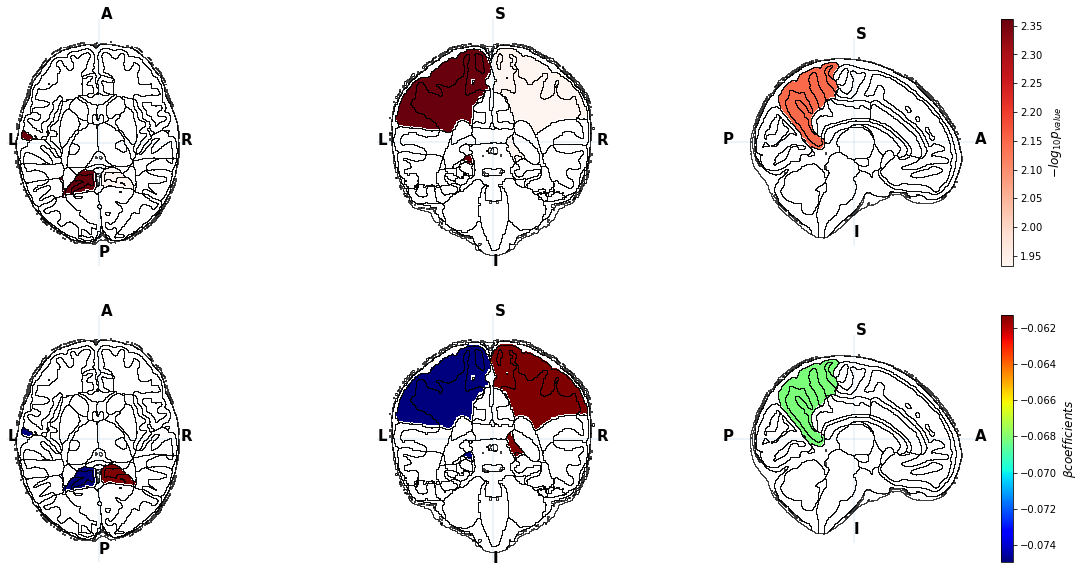

In [37]:
significant_regions = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_0.01'].copy()

plot_values_pvals = {indx+1:-np.log10(value) for indx,value in enumerate(significant_regions['PRS_pval'])}

plot_values_coefs = {indx+1:value for indx,value in enumerate(significant_regions['PRS_coef'])}

fig, axes = plt.subplots(2,3,figsize=(20,10))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['all'],
                                                              plot_values=plot_values_pvals,
                                                              plot_values_threshold=-np.log10(0.05),
                                                              axes=axes[0,:],
                                                            fig = fig,
                                                              atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',
                                                              colorbar=True,
                                                              cb_orientation='vertical',
                                                              cb_title=r'$-log_{10}p_{value}$',
                                                              cmap='Reds',
                                                              cmap_reversed=False)

_, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['all'],
                                                              plot_values=plot_values_pvals,
                                                              plot_values_threshold=-np.log10(0.05),
                                                            mask = plot_values_coefs,
                                                              axes=axes[1,:],
                                                            fig = fig,
                                                              atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',
                                                              colorbar=True,
                                                              cb_orientation='vertical',
                                                              cb_title=r'$\beta coefficients$',
                                                              cmap='jet',
                                                              cmap_reversed=False)

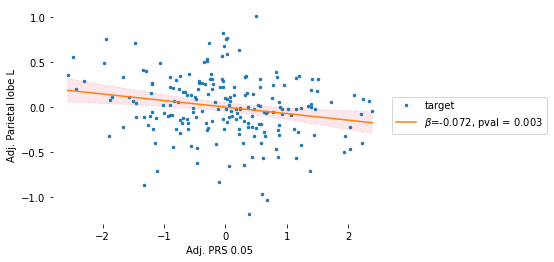

In [26]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=['Imperial 39'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_0.05'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 0.05', ylabel='Adj. Parietal lobe L',markersize=5,scaling='x')
sns.despine(left=True,right=True,bottom=True,top=True)

In [13]:
len(combined.columns)

84

In [82]:
# euro_WM = data_preprocessing.Volumes.extract_WM_Imperial(df)
# euro_GM = data_preprocessing.Volumes.extract_GM_Imperial(df)
# euro_DGM = data_preprocessing.Volumes.extract_deepGM_Imperial(df)
# deepGM = data_preprocessing.Volumes.extract_deepGM_Imperial([i for i in df.columns if bool(re.search('Imperial \d',i))])
combined = df[[
    i for i in df.columns
    if bool(re.search('Imperial \d', i))
]].copy()
# combined.drop(columns=deepGM,inplace=True)
# combined = pd.concat([euro_WM,euro_GM],axis=1)
# combined = df[[i for i in df.columns if 'PRS' in i]]
correlation_matrix = np.corrcoef(combined, rowvar=False)
data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 30.537095519088055
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 20.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.002499999999999996


In [155]:
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('Imperial \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components=.8)

In [141]:
0.05/7/7

0.0010204081632653062

In [142]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('Imperial \d',i))]


european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','Intracranial_Imperial']+ancestry,
    dependentVar_cols=X_pca)

100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 42.98it/s]


In [145]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if 'Euro' in i]


european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
87,Dependent_Var_3,0.104430,0.251763,-0.020866,0.804448,-0.463442,0.000239,0.237552,2.354691e-02,0.204492,0.002088,0.115645,0.074491,-0.039549,0.534357,0.131863,0.042549,-0.220702,0.113944,PRS_1e-07_ASD_Euro_LD
80,Dependent_Var_3,0.108964,0.231672,-0.037402,0.658978,-0.459112,0.000283,0.236233,2.451209e-02,0.200315,0.002511,0.119052,0.066340,-0.039214,0.537990,0.127802,0.047279,-0.230285,0.098819,PRS_1e-08_ASD_Euro_LD
149,Dependent_Var_2,-0.081308,0.417484,0.025639,0.782196,0.173632,0.201024,0.006898,9.518182e-01,-0.041379,0.569712,0.043653,0.540774,0.059069,0.396940,-0.133021,0.062920,0.171836,0.263524,PRS_1_ASD_Euro_LD
142,Dependent_Var_2,-0.082056,0.413990,0.027009,0.771257,0.169900,0.211437,0.008764,9.389353e-01,-0.039277,0.589922,0.040846,0.567201,0.060443,0.386892,-0.120960,0.090753,0.173417,0.260008,PRS_0.5_ASD_Euro_LD
92,Dependent_Var_1,0.099867,0.316180,-0.115315,0.213224,0.407979,0.002800,-0.375062,1.185582e-03,0.009832,0.890691,-0.044773,0.526480,-0.013230,0.849348,-0.114803,0.101839,-0.211058,0.166297,PRS_1e-06_ASD_Euro_LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Dependent_Var_5,-0.204175,0.043317,0.201145,0.031601,-0.259688,0.057245,0.146808,2.008253e-01,0.068408,0.349191,0.029579,0.679433,-0.012761,0.855130,-0.005125,0.942812,0.431503,0.005509,PRS_1_ASD_Euro_LD
97,Dependent_Var_6,0.067821,0.493708,0.017185,0.851857,-0.329783,0.014813,0.202608,7.563492e-02,-0.037027,0.603142,-0.133812,0.058184,-0.050672,0.465053,0.004268,0.951104,-0.143332,0.344273,PRS_1e-06_ASD_Euro_LD
119,Dependent_Var_0,0.080262,0.003056,-0.052990,0.033800,0.120311,0.001032,0.876817,1.646798e-72,-0.001015,0.957854,-0.010528,0.581091,-0.002878,0.877267,-0.001007,0.957800,-0.169625,0.000054,PRS_0.01_ASD_Euro_LD
150,Dependent_Var_3,0.112500,0.222382,-0.020605,0.808835,-0.493122,0.000102,0.258901,1.426715e-02,0.191857,0.004489,0.120594,0.066829,-0.026836,0.674970,0.003045,0.962869,-0.237757,0.092744,PRS_1_ASD_Euro_LD


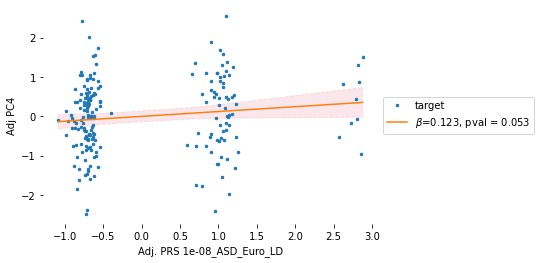

In [150]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=X_pca[:,3].reshape(-1,1))
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_1e-08_ASD_Euro_LD'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 1e-08_ASD_Euro_LD',ylabel='Adj PC4',markersize=5,scaling='x')
sns.despine(left=True,right=True,bottom=True,top=True)

In [156]:
loading_values = loading_matrix[3].values
loading_labels = [int(i.replace('Imperial ','')) for i in loading_matrix.index.tolist()]

In [152]:
loading_matrix = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_1e-07_ASD_Euro_LD'].copy()

In [153]:
loading_labels = [int(i.replace('Imperial ','')) for i in loading_matrix.Connection.tolist()]
loading_values = -np.log10(loading_matrix['PRS_pval'].values)

ValueError: invalid literal for int() with base 10: 'Dependent_Var_0'

In [159]:
plot_values=dict(zip(loading_labels,loading_values))

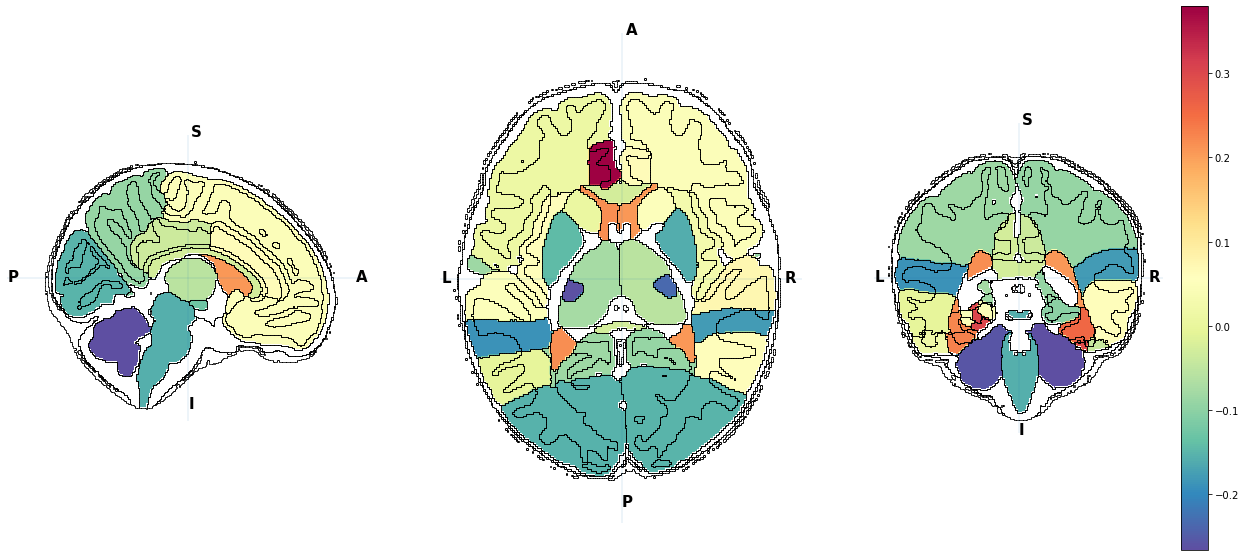

In [161]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],regions_to_hide=[83,84,85],plot_values=dict(zip(loading_labels,loading_values)),colorbar=True,atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',orientation='vertical',cmap_reversed=True)

In [102]:
loading_matrix.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
626,Imperial 39,0.106360,0.002147,-0.023500,0.460970,0.145867,0.001887,0.821106,3.166235e-52,-0.021323,0.387317,-0.022125,0.364891,0.068321,0.004547,-0.074275,0.002290,-0.224782,0.000027,PRS_0.05
669,Imperial 82,0.106360,0.002147,-0.023500,0.460970,0.145867,0.001887,0.821106,3.166235e-52,-0.021323,0.387317,-0.022125,0.364891,0.068321,0.004547,-0.074275,0.002290,-0.224782,0.000027,PRS_0.05
625,Imperial 38,0.077725,0.027281,-0.001627,0.960144,0.122770,0.010193,0.833785,7.581033e-52,-0.006690,0.790535,-0.013127,0.598618,0.074751,0.002419,-0.071013,0.004271,-0.164265,0.002429,PRS_0.05
668,Imperial 81,0.077725,0.027281,-0.001627,0.960144,0.122770,0.010193,0.833785,7.581033e-52,-0.006690,0.790535,-0.013127,0.598618,0.074751,0.002419,-0.071013,0.004271,-0.164265,0.002429,PRS_0.05
594,Imperial 7,0.103206,0.116151,-0.130023,0.033834,0.331447,0.000239,0.524381,3.301860e-11,0.007316,0.876638,-0.081357,0.082343,-0.047043,0.302648,0.072285,0.117424,-0.218116,0.030473,PRS_0.05
640,Imperial 53,0.103206,0.116151,-0.130023,0.033834,0.331447,0.000239,0.524381,3.301860e-11,0.007316,0.876638,-0.081357,0.082343,-0.047043,0.302648,0.072285,0.117424,-0.218116,0.030473,PRS_0.05
589,Imperial 2,0.055418,0.420161,0.020557,0.747719,-0.019350,0.835210,0.744486,6.750234e-18,-0.014436,0.770296,0.001933,0.968490,0.049428,0.301845,-0.075442,0.119272,-0.117120,0.265883,PRS_0.05
607,Imperial 20,0.100870,0.055257,-0.027963,0.566227,0.002207,0.975178,0.832929,3.224413e-31,0.027544,0.465254,-0.012880,0.729998,-0.046134,0.206612,0.057497,0.119455,-0.213179,0.008379,PRS_0.05
650,Imperial 63,0.100870,0.055257,-0.027963,0.566227,0.002207,0.975178,0.832929,3.224413e-31,0.027544,0.465254,-0.012880,0.729998,-0.046134,0.206612,0.057497,0.119455,-0.213179,0.008379,PRS_0.05
616,Imperial 29,0.004149,0.935496,0.098326,0.040297,-0.128259,0.065803,0.929503,3.513508e-37,-0.013221,0.720120,0.028633,0.433366,-0.003974,0.911304,-0.053962,0.135315,-0.008768,0.910997,PRS_0.05


In [162]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates(atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz')

In [163]:
ROIs_coord = ROIs_coord[~ROIs_coord['Label'].isin([83,84,85])]

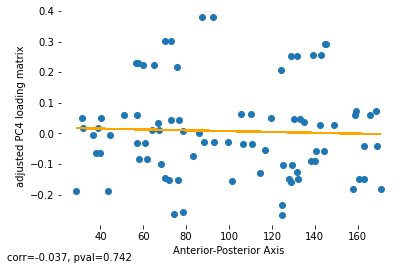

In [167]:
visualisation.plot_correlation(ROIs_coord['X'],loading_values,xlabel='Anterior-Posterior Axis',ylabel=r'adjusted PC4 loading matrix')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

In [ ]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=dependentVar_cols,
                                                    thresholds=thresholds)

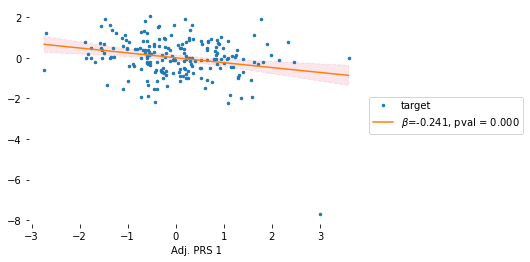

In [149]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=['Imperial 38'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_1e-06'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 1',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

We get the following summary table of R2, beta and p-value of association between PRS and brain volumes

In [14]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=['Imperial 79', 'Imperial 58', 'Imperial 12', 'WM_sum_Imperial'],
                                                    thresholds=thresholds)

In [15]:
summary_table

GA_vol       PMA_vol  \
Imperial 79     PRS_1e-08 R2     2.151483e-07  5.581806e-02   
                          Beta   1.163305e-03 -4.655917e-01   
                          P_val  9.737014e-01  2.193130e-16   
                PRS_1e-07 R2     2.151483e-07  5.581806e-02   
                          Beta  -4.715114e-05 -4.633134e-01   
...                                       ...           ...   
WM_sum_Imperial PRS_0.5   Beta  -2.090412e-02 -3.504964e-01   
                          P_val  4.976230e-01  7.648056e-13   
                PRS_1     R2     2.069066e-04  3.168293e-02   
                          Beta  -2.117077e-02 -3.491695e-01   
                          P_val  4.918391e-01  9.191190e-13   

                                 Intracranial_Imperial  mixed_Anc_PC1  \
Imperial 79     PRS_1e-08 R2              4.345161e-01       0.000042   
                          Beta            1.111430e+00       0.001041   
                          P_val           1.504568e-69       0.972560   
                PRS_1e-07 R2              4.345161e-01       0.000042   
                          Beta            1.109018e+00      -0.000937   
...                                                ...            ...   
WM_sum_Imperial PRS_0.5   Beta            1.092073e+00      -0.000195   
                          P_val           1.989428e-78       0.995132   
                PRS_1     R2              4.196961e-01       0.000481   
                          Beta            1.090843e+00      -0.002398   
                          P_val           2.625290e-78       0.940021   

                                 mixed_Anc_PC2  mixed_Anc_PC3  mixed_Anc_PC4  \
Imperial 79     PRS_1e-08 R2          0.000154       0.001059       0.000422   
                          Beta       -0.029123      -0.063549       0.024028   
                          P_val       0.570351       0.226530       0.406298   
                PRS_1e-07 R2          0.000154       0.001059       0.000422   
                          Beta       -0.028789      -0.063398       0.024302   
...                                        ...            ...            ...   
WM_sum_Imperial PRS_0.5   Beta        0.024430       0.001851       0.022922   
                          P_val       0.585327       0.968076       0.363892   
                PRS_1     R2          0.000128       0.000014       0.000426   
                          Beta        0.024602       0.002582       0.022865   
                          P_val       0.582377       0.955443       0.364681   

                                 mixed_Anc_PC5  Gender  PRS_1e-08  ...  \
Imperial 79     PRS_1e-08 R2          0.000126     0.0   0.000000  ...   
                          Beta       -0.009900     NaN  -0.074038  ...   
                          P_val       0.721709     NaN   0.005687  ...   
                PRS_1e-07 R2          0.000126     0.0        NaN  ...   
                          Beta       -0.010466     NaN        NaN  ...   
...                                        ...     ...        ...  ...   
WM_sum_Imperial PRS_0.5   Beta       -0.020695     NaN        NaN  ...   
                          P_val       0.394847     NaN        NaN  ...   
                PRS_1     R2          0.000294     0.0        NaN  ...   
                          Beta       -0.020826     NaN        NaN  ...   
                          P_val       0.391380     NaN        NaN  ...   

                                 PRS_1e-07  PRS_1e-06  PRS_1e-05  PRS_0.0001  \
Imperial 79     PRS_1e-08 R2           NaN        NaN        NaN         NaN   
                          Beta         NaN        NaN        NaN         NaN   
                          P_val        NaN        NaN        NaN         NaN   
                PRS_1e-07 R2      0.000000        NaN        NaN         NaN   
                          Beta   -0.076941        NaN        NaN         NaN   
...                                    ...        ...        ...         ..

We get the following plots

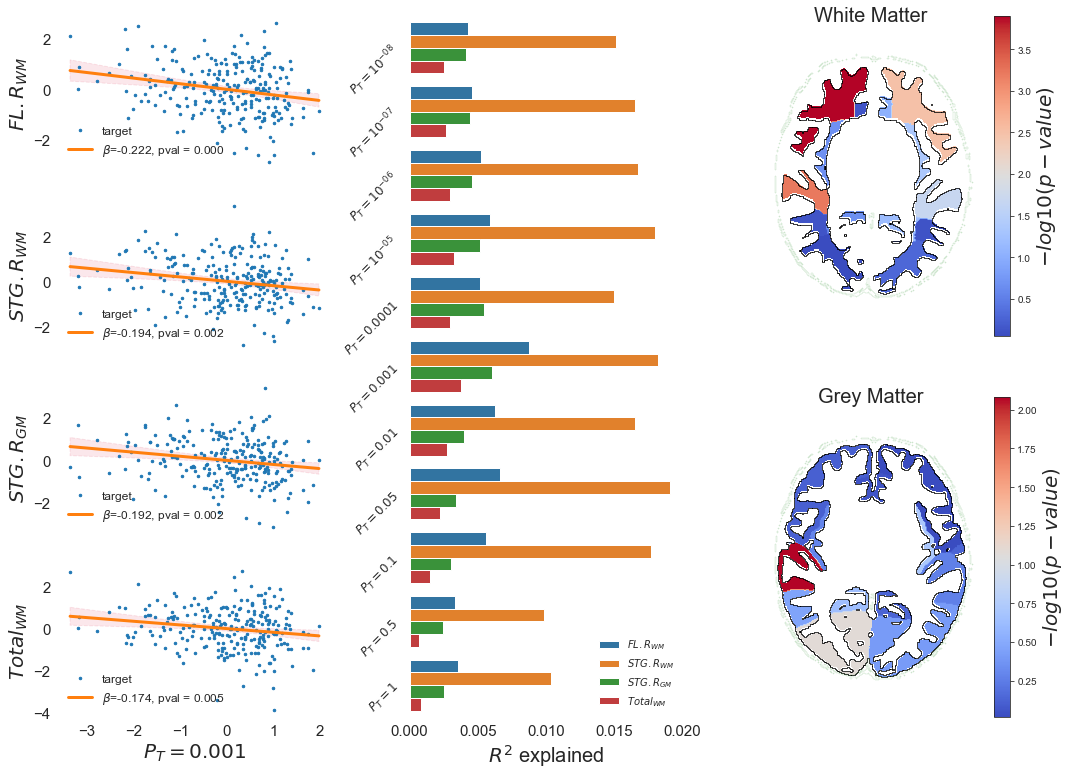

In [138]:
sns.set_style('white')
fig,axes = plt.subplots(4,3,sharex = True,figsize=(15,11))
# fig = plt.figure(figsize=(20,10))
# ax1 = plt.subplot(4,3,1)
# ax2 = plt.subplot(4,3,4)
# ax3 = plt.subplot(4,3,7)
# ax4 = plt.subplot(4,3,10)
for ax in axes[:,1:].flatten():
    ax.remove()
bar_plot = plt.subplot(132)
WM_plot = plt.subplot(233)
GM_plot = plt.subplot(236)
# plt.tight_layout(w_pad =.5, h_pad=.2)
dependent_var = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']
ylbl = ['$FL.R_{WM}$', '$STG.R_{WM}$', '$STG.R_{GM}$','$Total_{WM}$']
threshold = 'PRS_0.001'
thresholds_label = '$P_T = 0.001$'
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1,4)]
# axes = axes.flatten()
df = mixed_volumetric_dataset_term
# draw the scatter plot
for ax,dependent_variable, ylabel in zip(axes[:,0],dependent_var,ylbl):
    model, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                              cat_independentVar_cols=['Gender'],
                                                              cont_independentVar_cols=[
                                                                  'GA_vol','PMA_vol','Intracranial_Imperial'
                                                              ]+ancestry_list,
                                                              dependentVar_cols=[dependent_variable])
    visualisation.plot_Linear_Reg(x = df[[threshold]].values,
                                 y = model.resid.values,
                                 data = df,
                                 ylabel = ylabel,
                                 xlabel = f'{threshold}',
                                 axes=ax,legend_loc='inside',linewidth = 3,markersize=5)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(None,fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=15)
    ax.legend(loc='lower left',fontsize=12,frameon=False)
    sns.despine(bottom=True,left=True,right=True)
axes[-1,0].set_xlabel(f'{thresholds_label}',fontsize=20)

    
#draw the barplot of R-squared explained
Rsquared_explained_list = defaultdict(dict)
for dependent_variable in dependent_var:
    Rsquared_explained_list[dependent_variable] = defaultdict(list)
    for threshold in [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]:
        Rsquared_explained_list[dependent_variable][threshold] = data_exploration.MassUnivariate.calculate_R_squared_explained(df = df,col_to_drop=threshold,cat_independentVar_cols=['Gender'],cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry_list,dependentVar_cols=[dependent_variable])
Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_list)
Rsquared_explained_pd.columns = ylbl

Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_pd.unstack()).reset_index()
Rsquared_explained_pd.columns = ['Region','Threshold','$R^{2}$ explained']

g = sns.barplot(y = 'Threshold',x = '$R^{2}$ explained', data = Rsquared_explained_pd,hue = 'Region',ax = bar_plot)
# g.set_xlabel(rotation=90)
sns.despine(bottom=True,left=True,right=True)
bar_plot.set_xlabel('$R^{2}$ explained',fontsize=20)
bar_plot.set_ylabel(None,fontsize=20)
g.set_yticklabels(['$P_T = 10^{-08}$','$P_T = 10^{-07}$',
                     '$P_T = 10^{-06}$','$P_T = 10^{-05}$',
                     '$P_T = 0.0001$','$P_T = 0.001$',
                     '$P_T = 0.01$','$P_T = 0.05$',
                    '$P_T = 0.1$','$P_T = 0.5$','$P_T = 1$'],fontsize=12,rotation = 45)
g.tick_params(axis='x', labelsize=15)
bar_plot.legend(frameon=False)

#import the atlas
import nibabel as nib
FOLDER_PATH = f'{dataset_path}/visualise/Imperial/'  # please change to your own path

atlas_file = nib.load(FOLDER_PATH + 'atlas_t40.nii.gz')
atlas_aff = atlas_file.affine
atlas = atlas_file.get_fdata()

df = mixed_volumetric_term_mass_univariate[mixed_volumetric_term_mass_univariate['threshold'] == 'PRS_0.001'].copy()

df = df[[bool(re.search(r'[1-9]',i)) for i in df['Connection']]].sort_values(by='PRS_pval').reset_index(drop=True)
df['Connection_ID'] = [int(i.split(' ')[1]) for i in df['Connection']]

# Create a new volume of the same size as the atlas
atlas_coeffs_WM = np.zeros_like(atlas)
atlas_coeffs_GM = np.zeros_like(atlas)


WM_df = extract_WM_Imperial(df).reset_index(drop=True)
GM_df = extract_GM_Imperial(df).reset_index(drop=True)
# fig,axes = plt.subplots(1,2,figsize=(20,10))
# Here you will replace each index (0...87) from the atlas with the coefficients you want to plot
for i in WM_df['Connection_ID'].tolist():
    atlas_coeffs_WM[atlas == i] = -np.log10(WM_df.loc[WM_df['Connection_ID'] == i,'PRS_pval'].values)

for i in GM_df['Connection_ID'].tolist():
    atlas_coeffs_GM[atlas == i] = -np.log10(GM_df.loc[GM_df['Connection_ID'] == i,'PRS_pval'].values)


# im1 = WM_plot.imshow(np.rot90(atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]),cmap='coolwarm')
# im2 = GM_plot.imshow(np.rot90(atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]),cmap='coolwarm')

import copy
from matplotlib.collections import LineCollection

cmap = copy.copy(plt.cm.get_cmap('coolwarm'))
cmap.set_bad(alpha=0)

# atlas_coeffs_WM[atlas==84] = 0.1
WM_atlas = atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]
GM_atlas = atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]

WM_atlas[WM_atlas==0] = np.nan
GM_atlas[GM_atlas==0] = np.nan

im1 = WM_plot.imshow(np.rot90(WM_atlas),cmap=cmap)
im2 = GM_plot.imshow(np.rot90(GM_atlas),cmap=cmap)

WM_atlas[np.isnan(WM_atlas)] = 0
GM_atlas[np.isnan(GM_atlas)] = 0

brain_background = np.zeros(atlas.shape)
brain_background[atlas==84] = 1
brain_background = brain_background[:, :, brain_background.shape[2]//2]

cl_WM = LineCollection(visualisation.get_edges(np.rot90(WM_atlas)),lw=1,color='k')
WM_plot.add_collection(cl_WM)

cl_GM = LineCollection(visualisation.get_edges(np.rot90(GM_atlas)),lw=1,color='k')
GM_plot.add_collection(cl_GM)


cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
WM_plot.add_collection(cl_background)
cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
GM_plot.add_collection(cl_background)

for im,ax in zip([im1,im2],[WM_plot,GM_plot]):
    cbar = plt.colorbar(im,ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar.set_label('$-log10(p-value)$', fontsize=20)
WM_plot.set_title('White Matter',fontsize=20)
GM_plot.set_title('Grey Matter', fontsize=20)
# WM_plot.set_ylabel('White Matter',fontsize=20)
# GM_plot.set_ylabel('Grey Matter',fontsize=20)
plt.tight_layout()
fig.savefig(f'{preprocessed_dataset_path}/output_plot/all_plots_mixed.svg')

# Other tests

### High and low risk

In [142]:
threshold = 'PRS_0.01_ASD_Euro_LD'
dependentVar = ['Brain_PC4']


def high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc):
    high_risk, low_risk = data_exploration.Stability_tests.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(df,
                                                                       cont_independentVar_cols=ancestry_PCs,
                                                                       dependentVar_cols=[threshold]),
        low_perc=perc,
        high_perc=perc)
    temp_high_risk = df.loc[high_risk.index, dependentVar].reset_index(drop=True)
    temp_high_risk['Percentages'] = perc
    temp_high_risk['Risk'] = 'High'
    temp_low_risk = df.loc[low_risk.index, dependentVar].reset_index(drop=True)
    temp_low_risk['Percentages'] = perc
    temp_low_risk['Risk'] = 'Low'
    return pd.concat([temp_high_risk, temp_low_risk])


risk_df = pd.concat([
    high_low_risk_for_catplot(df, dependentVar, ancestry, threshold, perc) for perc in [0.1,0.2,0.3,0.4]])
risk_df = risk_df.reset_index(drop=True)

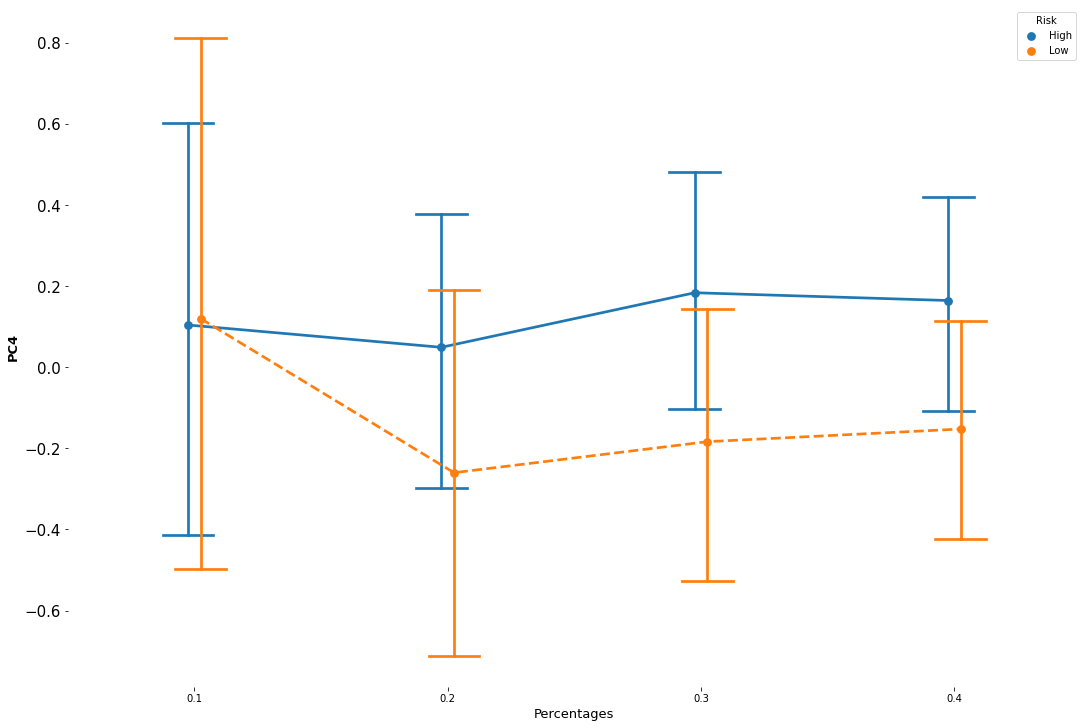

In [144]:
fig,axes = plt.subplots(1,1,figsize=(15,10),constrained_layout=True,sharex=True)
# axes[1,1].remove()
# axes = axes.flatten()
for ax, variable,var_name in zip([axes],dependentVar,['PC4']):
    sns.pointplot(x='Percentages',
                  y=variable,
                  data=risk_df,
                  hue='Risk',
                  dodge=True,
#                  markers=['o','x'],
                 linestyles=['-','--'],capsize=.2,ax=ax)
    sns.despine(top=True,bottom=True,right=True,left=True)
    ax.set_ylabel(var_name,fontdict={'fontsize':13,'fontweight':'bold'})
    ax.set_xlabel('Percentages',fontdict={'fontsize':13})
    ax.tick_params(axis='y', labelsize=15)
# plt.savefig(f'{preprocessed_dataset_path}/output_plot/high_low_risk_european.svg')

In [149]:
risk_df.columns

Index(['Brain_PC4', 'Percentages', 'Risk'], dtype='object')

In [153]:
[data_exploration.Stability_tests.perform_t_test(risk_df.loc[(risk_df['Percentages']==perc)&(risk_df['Risk']=='High'),'Brain_PC4'].values,risk_df.loc[(risk_df['Percentages']==perc)&(risk_df['Risk']=='Low'),'Brain_PC4'].values) for perc in [0.1,0.2,0.3,0.4]]

[(-0.035070039746550825, 0.9721983212441256),
 (1.0477709603778798, 0.29789939990088826),
 (1.6395391634177903, 0.10367715718866838),
 (1.5771528420636391, 0.11671110274633925)]

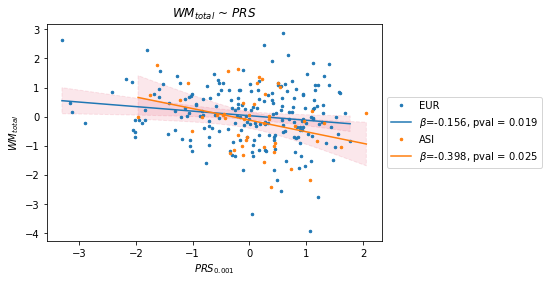

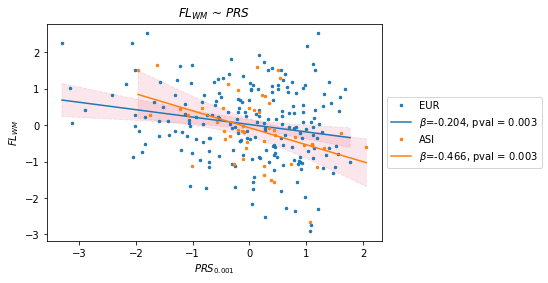

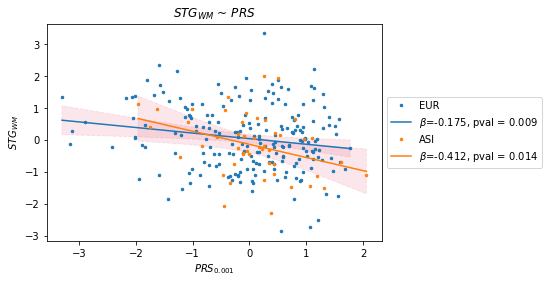

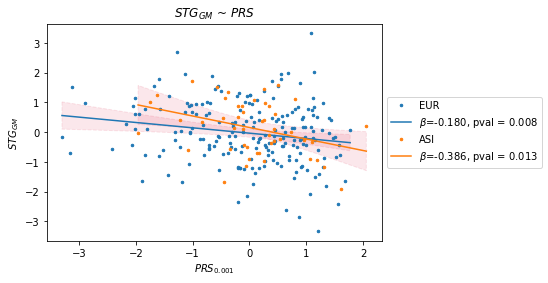

In [11]:
dependent_var = [
    'WM_sum_Imperial', 'Imperial 79', 'Imperial 58', 'Imperial 12'
]
ylbl = ['$WM_{total}$', '$FL_{WM}$', '$STG_{WM}$', '$STG_{GM}$']
ancestry = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
df = mixed_volumetric_dataset_term

for var, ylabel in (zip(dependent_var, ylbl)):
    model, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=[
            'GA_vol', 'PMA_vol', 'Intracranial_Imperial'
        ],
        dependentVar_cols=[var])
    model2, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cont_independentVar_cols=ancestry,
        dependentVar_cols=['PRS_0.001'])
#     plt.style.use('seaborn-whitegrid')
    visualisation.plot_Linear_Reg(
        model2.resid.values,
        model.resid.values,
        data=mixed_volumetric_dataset_term,
        ylabel=ylabel,
        xlabel='$PRS_{0.001}$',
        hue='cohort',
        title='%s ~ $PRS$' % ylabel,
        combined=False,
    markersize=5)

## Other tests

### check if removing or adding variables changes the R2

In [13]:
all_models = data_exploration.MassUnivariate.check_all_predictors_combo_linear_Reg(df = mixed_volumetric_dataset_term,
                                           cat_independentVar_cols=['Gender'],
                                           cont_independentVar_cols=['PRS_0.001','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3',
                                                                     'mixed_Anc_PC4','mixed_Anc_PC5',
                                                                    'GA_vol','PMA_vol','Intracranial_Imperial'],
                                          dependentVar_cols=['WM_sum_Imperial'])

100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


In [15]:
model_score_summary, model_var_summary, model_beta_summary, model_p_summary = data_exploration.MassUnivariate.preprocess_forward_selection(all_models)

The best model is when including all the covariates, but with less it still achieves similar results

In [22]:
model_score_summary.sort_values(by='R2',ascending=False)

,N_var,AIC,R2,R2_adj
1023,10,215.648386,8.756160e-01,8.705597e-01
1018,9,213.648958,8.756157e-01,8.710835e-01
1020,9,213.742773,8.755703e-01,8.710364e-01
994,8,211.747326,8.755681e-01,8.715541e-01
1019,9,213.916692,8.754860e-01,8.709491e-01
...,...,...,...,...
7,1,731.878817,5.647762e-03,1.748342e-03
47,2,735.165348,6.575971e-04,-7.211241e-03
8,1,733.195754,5.393560e-04,-3.380098e-03
6,1,733.309411,9.725271e-05,-3.823935e-03


<AxesSubplot:xlabel='N_var'>

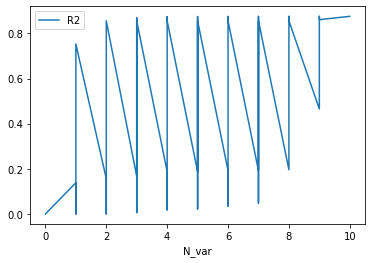

In [24]:
model_score_summary.plot('N_var','R2')

### adding preterm

In [29]:
european_volumetric_preterm_term_mass_univariate = pd.read_csv(
    './preprocessed_dataset/imaging_data/volumetric/preterm_term/european_volumetric_preterm_term_mass_univariate.csv'
)

In [32]:
data_preprocessing.Volumes.extract_WM_Imperial(european_volumetric_preterm_term_mass_univariate).sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
630,Imperial 79,0.089234,0.009166,0.222168,1.095722e-10,-0.598642,1.375070e-21,-0.036649,0.158641,-0.028282,0.262465,0.019237,0.433409,1.248126,4.956868e-67,-0.070116,0.005742,-0.197588,0.000222,PRS_0.1
558,Imperial 79,0.088570,0.009781,0.221963,1.188279e-10,-0.599497,1.328617e-21,-0.034744,0.180228,-0.028948,0.252092,0.019136,0.436547,1.249594,4.398070e-67,-0.067245,0.007844,-0.196119,0.000251,PRS_0.05
414,Imperial 79,0.086724,0.011485,0.222626,1.086336e-10,-0.605411,5.751416e-22,-0.031050,0.227522,-0.027863,0.270361,0.014314,0.558126,1.255667,1.133521e-67,-0.064906,0.009110,-0.192031,0.000343,PRS_0.001
270,Imperial 79,0.086523,0.011685,0.222842,1.049350e-10,-0.608548,3.778565e-22,-0.027886,0.275968,-0.026680,0.291166,0.011953,0.624339,1.259979,4.896486e-68,-0.064263,0.009188,-0.191586,0.000354,PRS_1e-05
280,WM_sum_Imperial,0.094424,0.000977,0.186887,7.194661e-11,-0.494796,1.970774e-21,-0.020011,0.346474,-0.022522,0.283408,0.005777,0.775667,1.222138,4.033948e-80,-0.052604,0.010241,-0.209081,0.000003,PRS_1e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,Imperial 55,-0.014055,0.814985,0.294812,7.870784e-07,-0.267992,8.047819e-03,0.062955,0.168771,0.029200,0.512209,0.001909,0.964887,0.784182,5.136692e-16,-0.001004,0.981913,0.031123,0.738435,PRS_0.05
339,Imperial 66,0.102358,0.041317,0.060628,2.105757e-01,-0.551098,2.278240e-10,0.000105,0.997776,-0.027987,0.449537,-0.024654,0.490684,1.202985,3.573970e-40,0.000623,0.986190,-0.226651,0.003773,PRS_0.0001
254,Imperial 51,0.075592,0.178395,0.035679,5.111853e-01,0.075170,4.215992e-01,-0.000051,0.999042,-0.022600,0.586387,-0.015904,0.691993,0.693568,7.734637e-15,0.000643,0.987273,-0.167383,0.055429,PRS_1e-05
38,Imperial 51,0.075549,0.178456,0.035702,5.108313e-01,0.075171,4.215911e-01,-0.000130,0.997530,-0.022595,0.586482,-0.015888,0.692314,0.693525,7.580347e-15,-0.000250,0.995037,-0.167286,0.055354,PRS_1e-08
